In [171]:
# General
import sys
import os
import os.path as op
import glob
from copy import deepcopy
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import warnings
from cluster_helper.cluster import cluster_view

# Scientific
import numpy as np
import xarray
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
from scipy import signal
from scipy.io import loadmat
import h5py

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import astropy.stats.circstats as circstats
import pycircstat
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

# Neuro
import mne
from fooof import FOOOF, FOOOFGroup
from fooof.objs.utils import combine_fooofs

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
from formatting import *
from helper_funcs import *
import data_io as dio
import array_operations as aop
import spectral_processing as spp
import manning_utils
import manning_analysis
import phase_locking
import lfp_synchrony
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc
from phase_locking import eeg_preproc, spectral_analysis, unit_lfp_comparison

# Colors
colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

proj_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta'

# Plot example spectrograms

In [114]:
subj_sess = 'U540_ses0'
lfp_hemroi = 'RAH'
data_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav'

# -----------------------------------------
basename_lfp = '{}-{}.pkl'.format(subj_sess, lfp_hemroi)
power = dio.open_pickle(op.join(data_dir, 'spectral', 'power', basename_lfp))
print('power: {}'.format(power.shape))

power: (72, 8, 30, 30000)


In [162]:
# -----------------------
# Load EEG for each channel and event.
subj_sess = 'U540_ses0'
roi = 'RAH'
iChan = 0
game_states = ['Encoding', 'Retrieval']
buffer = 0
l_freq = 0.1
h_freq = 80
notch_freqs = [60]
chan_exclusion_thresh = 2
verbose = True

event_eeg = eeg_preproc.load_event_eeg(subj_sess,
                                       regions=[roi],
                                       game_states=game_states,
                                       buffer=buffer,
                                       l_freq=l_freq,
                                       h_freq=h_freq,
                                       notch_freqs=notch_freqs,
                                       chan_exclusion_thresh=chan_exclusion_thresh,
                                       verbose=verbose)
event_eeg = event_eeg[roi].stack(event=('gameState', 'trial')).transpose('event', 'chan', 'time')
event_eeg = event_eeg.isel(chan=[iChan])

# -----------------------
# Save power and phase at each timepoint, for each channel and event.
freqs = np.linspace(1, 30, 88)
clip_buffer = False
n_cycles = 5
zero_mean = True
log_power = False
output_dir = op.join('/scratch/dscho/goldmine', 'nav', 'spectral')
save_output = False
overwrite = True
verbose = True

timer = Timer()
power = spectral_analysis.timefreq_wavelet(event_eeg,
                                           freqs,
                                           clip_buffer=clip_buffer,
                                           n_cycles=n_cycles,
                                           zero_mean=zero_mean,
                                           log_power=log_power,
                                           output='power',
                                           output_dir=output_dir,
                                           save_output=save_output,
                                           overwrite=overwrite,
                                           verbose=verbose)
print(timer)

U540_ses0
---------
Excluded RAH channel 1 (index 0)
Kept 7/8 (88%) channels across 1 regions
Ran in 5.0s

Ran in 28.0s


U540_ses0-RAH-CSC2
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/lfp_spectrograms/U540_ses0-RAH-CSC2.pdf


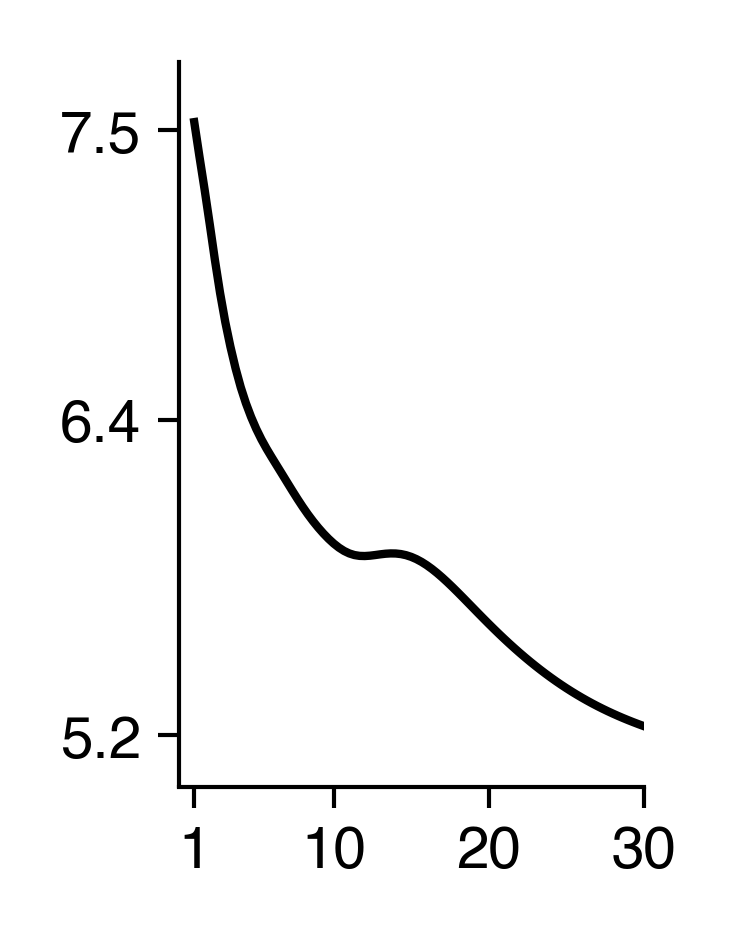

In [163]:
figsize = (1, 1.6)
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
linewidth = 1
ax_linewidth = 0.5
labelpad = 5
tickpad = 2
ticklen = 2.5
xvals = freqs
xticks = [1, 10, 20, 30]
xticklabs = xticks
xlim = (0, 30)
ylim = None  # (4.25, 7.25)
yticks = None  # [4.5, 5.5, 6.5]
yticklabs = yticks
lw = 1
plot_labels = False
output_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/figs2/lfp_spectrograms'
savefig = True
overwrite = True

# ------------------------
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]

print('{}-{}-CSC{}'.format(power.name[0], power.name[1], power.chan.values[0]))
# dat = np.nanmean(np.log10(power.values[:, iChan,...]), axis=(0, 2))
dat = np.log10(np.nanmean(power.values, axis=(0, 1, 3)))

if ylim is None:
    yrange = dat.max() - dat.min()
    ylim = (dat.min() - (0.1 * yrange), dat.max() + (0.1 * yrange))
if yticks is None:
    yticks = np.round(np.linspace(dat.min(), dat.max(), 3), 1)
    
_ax.plot(xvals, dat, lw=lw, color='k')
    
for spine in ('left', 'bottom'):
    _ax.spines[spine].set_linewidth(ax_linewidth)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=ax_linewidth)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_xlim(xlim)
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])

if (iax == 0) & (plot_labels):
    _ax.set_xlabel('Frequency (Hz)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_ylabel('Log-power', fontsize=font['label'], labelpad=labelpad)
else:
    _ax.set_xlabel('')
    _ax.set_ylabel('')
        
if savefig:
    filename = op.join(output_dir,
                       '{}-{}-CSC{}.pdf'
                       .format(power.name[0],
                               power.name[1],
                               power.chan.values[0]))
    if overwrite or not op.exists(filename):
        print('Saved {}'.format(filename))
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        
fig.show()

# Load data

In [2]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join('/data7', 'goldmine', 'analysis', 'events', '*.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

10 subjects, 12 sessions


In [ ]:
# Load the microwire montage.
subj_sess = 'U530_ses0'

hpc_rois = ['LAH', 'LMH', 'LPH', 'RAH', 'RMH', 'RPH']
mont = spike_preproc.get_montage(subj_sess)
mont_hpc = mont.loc[np.isin(mont.index, hpc_rois)]

# Load events.
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
events = events_proc.load_events(subj_sess, verbose=False)
events.event_times = events.event_times.query("(gameState=={})".format(game_states)).reset_index(drop=True)
events.event_times['start_time'] = events.event_times['time_bins'].apply(lambda x: x[0])
events.event_times['stop_time'] = events.event_times['time_bins'].apply(lambda x: x[-1])

print(events)
print('')
print(mont)
print('')
print(mont_hpc, sep='\n')

In [784]:
# Load LFP timestamps.
downsample_to = 1000

# ----------------------
timer = Timer()

lfp_timestamps, sr_orig = spike_sorting.load_lfp_timestamps(subj_sess, verbose=False)
downsample_by = int(sr_orig / downsample_to)
start = int(downsample_by / 2)
lfp_timestamps = lfp_timestamps[start::downsample_by]
sr = downsample_to

print('{}, lfp_timestamps: {}, original sr = {}Hz, new sr = {}Hz'
      .format(subj_sess, lfp_timestamps.shape, sr_orig, sr))
print(timer)

U530_ses0, lfp_timestamps: (4621742,), original sr = 30000Hz, new sr = 1000Hz
Ran in 5.8s


In [164]:
co

blue            #006BA2
cyan            #3EBCD2
red             #E3120B
yellow          #EBB434
green           #379A8B
light_green     #86E5D4
dark_cyan       #00788D
dark_red        #A81829
light_red       #FF8785
dark_yellow     #AA7C00
purple          #9A607F
dark_purple     #78405F
light_purple    #E6A6C7
olive           #B4BA39
dark_olive      #4C5900
gold            #D1B07C
dark_gold       #674E1F
gray            #B7C6CF
dark_gray       #3F5661
mid_gray        #758D99
light_gray      #E9EDF0
black           #000000
white           #FFFFFF
b               #006BA2
c               #3EBCD2
r               #E3120B
y               #EBB434
g               #379A8B
lg              #86E5D4
dc              #00788D
dr              #A81829
lr              #FF8785
dy              #AA7C00
p               #9A607F
dp              #78405F
lp              #E6A6C7
o               #B4BA39
do              #4C5900
a               #D1B07C
da              #674E1F
x               #B7C6CF
dx              

In [4]:
subj_sess = 'U539_ses0'
hemroi = 'LFSG'
l_freq = 0.1
h_freq = 80
notch_freqs = [60]
downsample_to = 1000
save_output = True
overwrite = False
verbose = False

timer = Timer()

chans = mont[hemroi]

eeg = []
for chan in chans:
    _eeg, sr = eeg_preproc.process_eeg(subj_sess,
                                       chan=chan,
                                       downsample_to=downsample_to,
                                       l_freq=l_freq,
                                       h_freq=h_freq,
                                       notch_freqs=notch_freqs,
                                       save_output=save_output,
                                       overwrite=overwrite,
                                       verbose=verbose)
    eeg.append(_eeg.tolist())
    timer.loop(verbose=verbose)

eeg = np.array(eeg)
print('eeg:', eeg.shape)

print(timer)

eeg: (8, 6678647)
Ran in 7.8s


In [7]:
subj_sess = 'U539_ses0'
regions = ['LFSG']
game_states = ['Encoding', 'Retrieval']
sr = 1000
buffer = 0 # 2500
chan_exclusion_thresh = 2
verbose = True

event_eeg = eeg_preproc.load_event_eeg(subj_sess,
                                       regions=regions,
                                       game_states=game_states,
                                       buffer=buffer,
                                       chan_exclusion_thresh=chan_exclusion_thresh,
                                       verbose=verbose)
event_eeg = event_eeg[roi]

for roi in event_eeg:
    print('{}: {}'.format(roi, event_eeg[roi].shape))

U539_ses0
---------
Kept 8/8 (100%) channels across 1 regions
Ran in 7.8s

LFSG: (2, 34, 8, 30000)


In [231]:
freqs = np.arange(1, 21)
n_cycles = 5
zero_mean = True
log_power = False

# ---------------------
timer = Timer()

power, phase = timefreq_wavelet(event_eeg[roi].stack(event=('gameState', 'trial')).transpose('event', 'chan', 'time'),
                                freqs,
                                n_cycles=n_cycles,
                                zero_mean=zero_mean,
                                log_power=log_power)
power = power.unstack('event').transpose('gameState', 'trial', 'chan', 'freq', 'time')
phase = phase.unstack('event').transpose('gameState', 'trial', 'chan', 'freq', 'time')

# Z-score power across gameState, trial, and time (within each channel x frequency).
zaxis = tuple(np.where(np.isin(power.dims, ['gameState', 'trial', 'time']))[0])
zpower = power.copy(data=stats.zscore(power.values,
                                      axis=zaxis))

print('power: {}, phase: {}'.format(power.shape, phase.shape))
print(timer)

Ran in 2.2s


# FOOOF

In [33]:
from neurodsp.spectral import compute_spectrum
from fooof import FOOOF
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.objs.utils import average_fg, combine_fooofs, compare_info
from fooof.plts import plot_spectrum, plot_spectra

In [38]:
subj_sess = 'U530_ses0'
roi = 'RMH'
sr = 1000
buffer = 0
chan_exclusion_thresh = 2
verbose = True

regions = [roi]
event_eeg = eeg_preproc.load_event_eeg(subj_sess,
                                       regions=regions,
                                       buffer=buffer,
                                       chan_exclusion_thresh=chan_exclusion_thresh,
                                       verbose=verbose)
event_eeg = event_eeg[roi].stack(event=('gameState', 'trial')).transpose('event', 'chan', 'time')

print('{}: {}'.format(roi, event_eeg.shape))

U530_ses0
---------
Kept 8/8 (100%) channels across 1 regions
Ran in 6.2s

RMH: (72, 8, 30000)


In [40]:
freqs = np.arange(1, 51)
clip_buffer = False
n_cycles = 5
zero_mean = True
log_power = False
output = 'both'
save_output = False
overwrite = False
verbose = True

# ---------------------
timer = Timer()

power, phase = spectral_analysis.timefreq_wavelet(event_eeg,
                                                  freqs,
                                                  clip_buffer=clip_buffer,
                                                  n_cycles=n_cycles,
                                                  zero_mean=zero_mean,
                                                  log_power=log_power,
                                                  output=output,
                                                  save_output=save_output,
                                                  overwrite=overwrite,
                                                  verbose=verbose)

# Calculate mean power across each interval.
if clip_buffer:
    mean_power = power.mean(dim='time') # event x chan x freq
else:
    mean_power = power[:, :, :, buffer:len(power.time)-buffer].mean(dim='time')

print('power: {}, phase: {}'.format(power.shape, phase.shape))
print(timer)

In [ ]:
# EEG proc params.
buffer = 2500
l_freq = 0.1
h_freq = 80
notch_freqs = [60]
chan_exclusion_thresh = 2
sr = 1000

# Power decomp params.
fmin = 1
fmax = 50
n_fft = int(sr)
n_overlap = int(sr/8)

# Plot params.
savefig = False
overwrite = False
figsize = (colws[2], colws[2])
dpi = 600
linewidth = 0.5
font = {'tick': 7, 'label': 8, 'fig': 8, 'annot': 7}
ax_linewidth = 0.5
labelpad = 6
xticklabs = [1, 10, 20, 30, 40, 50]
ticklen = 2.5
tickwidth = 0.5
tickpad = 2.5
show_grid = True

# ---------------------
# Do the spectral decomp.
_freqs = freqs.copy()
_powers = np.log10(mean_power.values.copy())
zpowers = stats.zscore(_powers, axis=(0, 1))
_powers = np.mean(_powers, axis=0) # chan x freq
zpowers = np.mean(zpowers, axis=0) # chan x freq

xvals = np.arange(len(_freqs))
xticklabs = [freq for freq in xticklabs if (freq in _freqs)]
xticks = [_freqs.tolist().index(freq) for freq in xticklabs]
        
plt.close()
linecolors = sns.color_palette('viridis', _powers.shape[0])
fig, ax = plt.subplots(1, 2, figsize=(colws[3], colws[3] * 0.4), dpi=600)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
for iChan in range(_powers.shape[0]):
    _ax.plot(xvals, _powers[iChan, :], color=linecolors[iChan])
_ax.set_ylabel('Log power', fontsize=font['label'], labelpad=labelpad)

iax = 1
_ax = ax[iax]
for iChan in range(_powers.shape[0]):
    _ax.plot(xvals, zpowers[iChan, :], color=linecolors[iChan])
_ax.set_ylabel('Z power', fontsize=font['label'], labelpad=labelpad)

for _ax in ax:
    _ax.grid(show_grid)
    _ax.tick_params(labelsize=font['tick'], axis='both', which='major', length=ticklen, width=tickwidth)
    for spine in ['left', 'bottom']:
        _ax.spines[spine].set_visible(True)
        _ax.spines[spine].set_linewidth(ax_linewidth)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_xlabel('Frequency (Hz)', fontsize=font['label'], labelpad=labelpad)

fig.suptitle('{}, {}'.format(subj_sess, roi), fontsize=font['fig'], y=1)
fig.tight_layout()
        
fig.show()

In [162]:
# Run FOOOF on spectral powers for each channel and event.
freqs = np.arange(1, 31)
peak_width_limits = (1, 8)
min_peak_height = 0.2
max_n_peaks = 4
peak_threshold = 2
aperiodic_mode = 'fixed'
save_output = True
overwrite = True

# -----------------------
warnings.filterwarnings('ignore')
timer = Timer()

fit_fixed = 0
fit_knee = 0
foofs = []
foof_diffs = []
for iChan in range(len(mean_power.chan)):
    for iEvent in range(len(mean_power.event)):
        fm_fixed = FOOOF(peak_width_limits=peak_width_limits,
                         max_n_peaks=max_n_peaks,
                         min_peak_height=min_peak_height,
                         peak_threshold=peak_threshold,
                         aperiodic_mode='fixed',
                         verbose=False)
        fm_fixed.fit(freqs, mean_power.values[iEvent, iChan, :freqs.size])
        foofs.append(fm_fixed)
        fit_fixed += 1
        foof_diffs.append(list(mean_power.values[iEvent, iChan, :freqs.size] - (10**fm_fixed._ap_fit)))
        
#         fm_knee = FOOOF(peak_width_limits=peak_width_limits,
#                         max_n_peaks=max_n_peaks,
#                         min_peak_height=min_peak_height,
#                         peak_threshold=peak_threshold,
#                         aperiodic_mode='knee',
#                         verbose=False)
#         fm_knee.fit(freqs, mean_power.values[iEvent, iChan, :freqs.size])
        
#         if fm_fixed.error_ < fm_knee.error_:
#             foofs.append(fm_fixed)
#             fit_fixed += 1
#             foof_diffs.append(list(mean_power.values[iEvent, iChan, :freqs.size] - (10**fm_fixed._ap_fit)))
#         else:
#             foofs.append(fm_knee)
#             fit_knee += 1
#             foof_diffs.append(list(mean_power.values[iEvent, iChan, :freqs.size] - (10**fm_knee._ap_fit)))

fg = combine_fooofs(foofs)
foof_diffs = np.array(foof_diffs)

if save_output:
    output_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/fooof'
    basename = '{}-{}'.format(subj_sess, roi)
    if overwrite or not op.exists(op.join(output_dir, basename)):
        fg.save(basename, output_dir, save_results=True, save_settings=True)
    
print('Fit fixed: {}, fit knee: {}'.format(fit_fixed, fit_knee))
print(timer)
warnings.resetwarnings()

Fit fixed: 576, fit knee: 0
Ran in 3.9s


In [163]:
# fixed
np.mean(foof_diffs, axis=0).astype(int), stats.sem(foof_diffs, axis=0).astype(int)

(array([115682, 395038, 120854,  53803,  20513,   4260,   4125,   6475,
          5419,   2684,    727,    215,    918,   2245,   3419,   3931,
          3773,   3240,   2630,   2090,   1641,   1248,    878,    518,
           178,   -130,   -396,   -614,   -786,   -919]),
 array([158110,  48468,   9324,   4613,   3959,   2916,   2413,   2097,
          1563,   1030,    690,    585,    593,    589,    591,    612,
           616,    581,    512,    427,    339,    260,    192,    139,
           101,     82,     80,     88,    100,    111]))

In [164]:
aop.unique(fg.n_peaks_, sort=False)

0    316
1    236
2     21
3      3
dtype: int64

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                            Number of power spectra in the Group: 576                             
                                                                                                  
                        The model was run on the frequency range 1 - 30 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

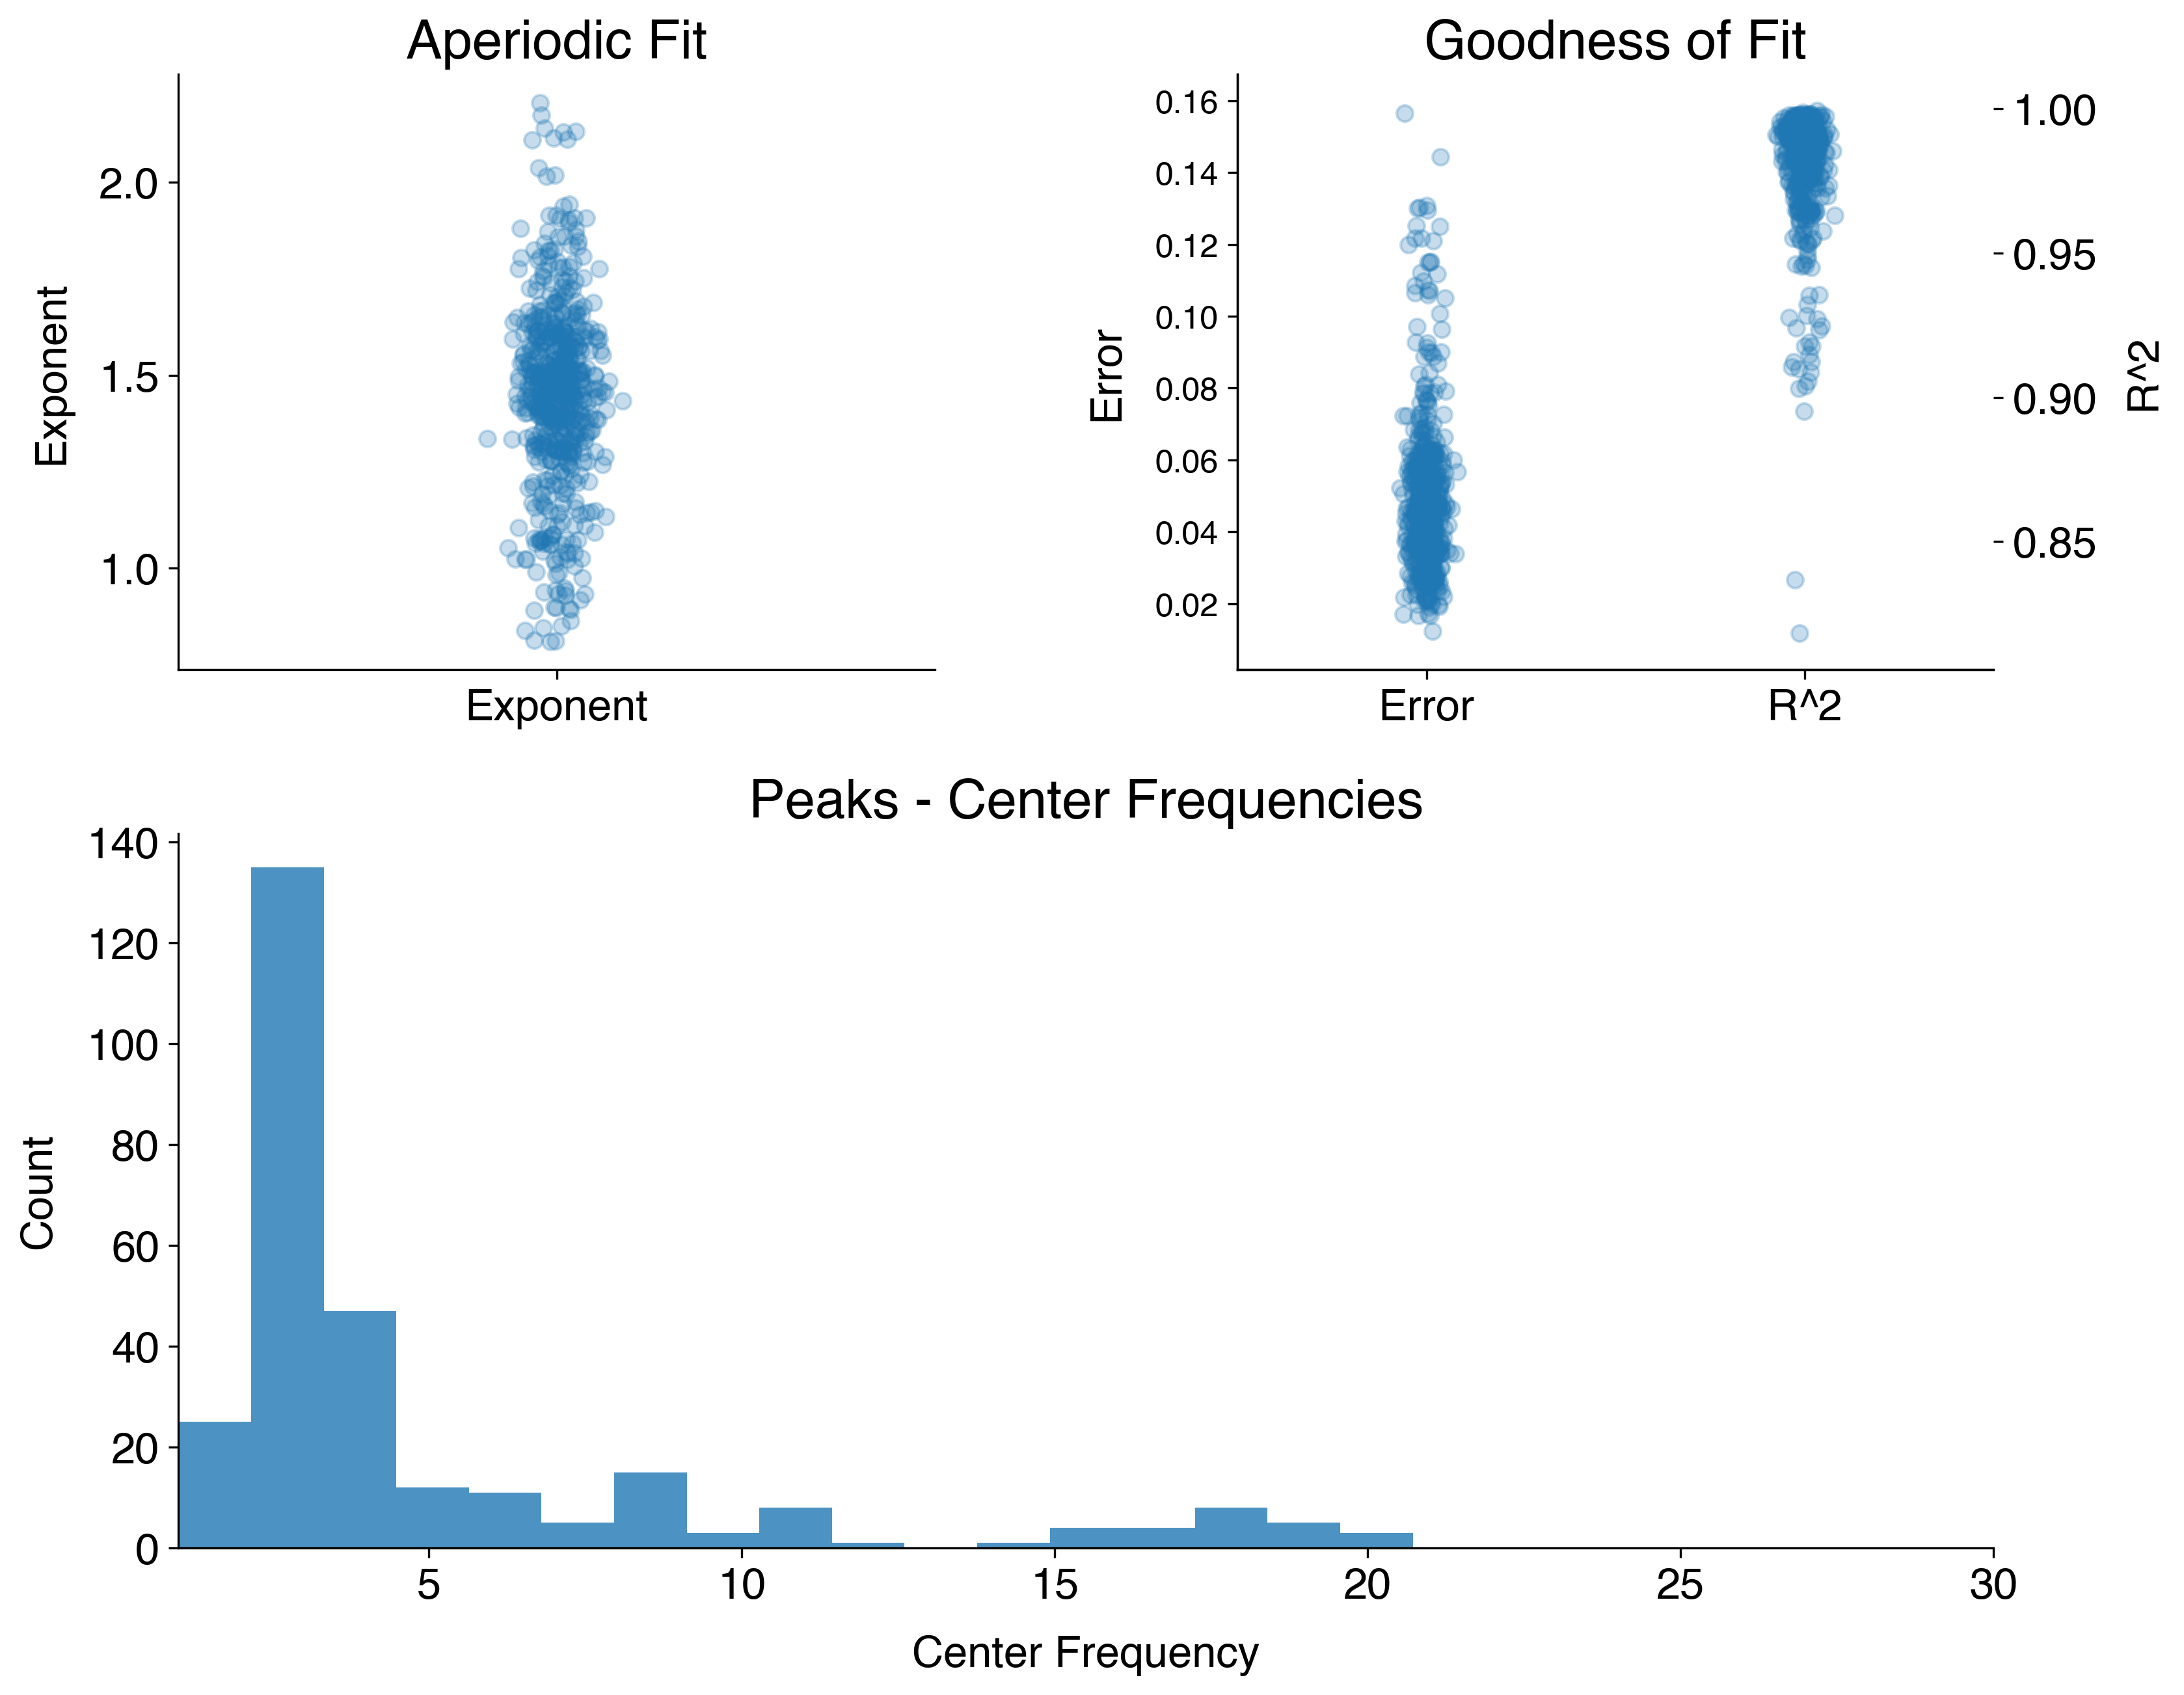

In [165]:
warnings.filterwarnings('ignore')
fg.report()
warnings.resetwarnings()

[[2.93181462 0.41920999 2.16512826]]


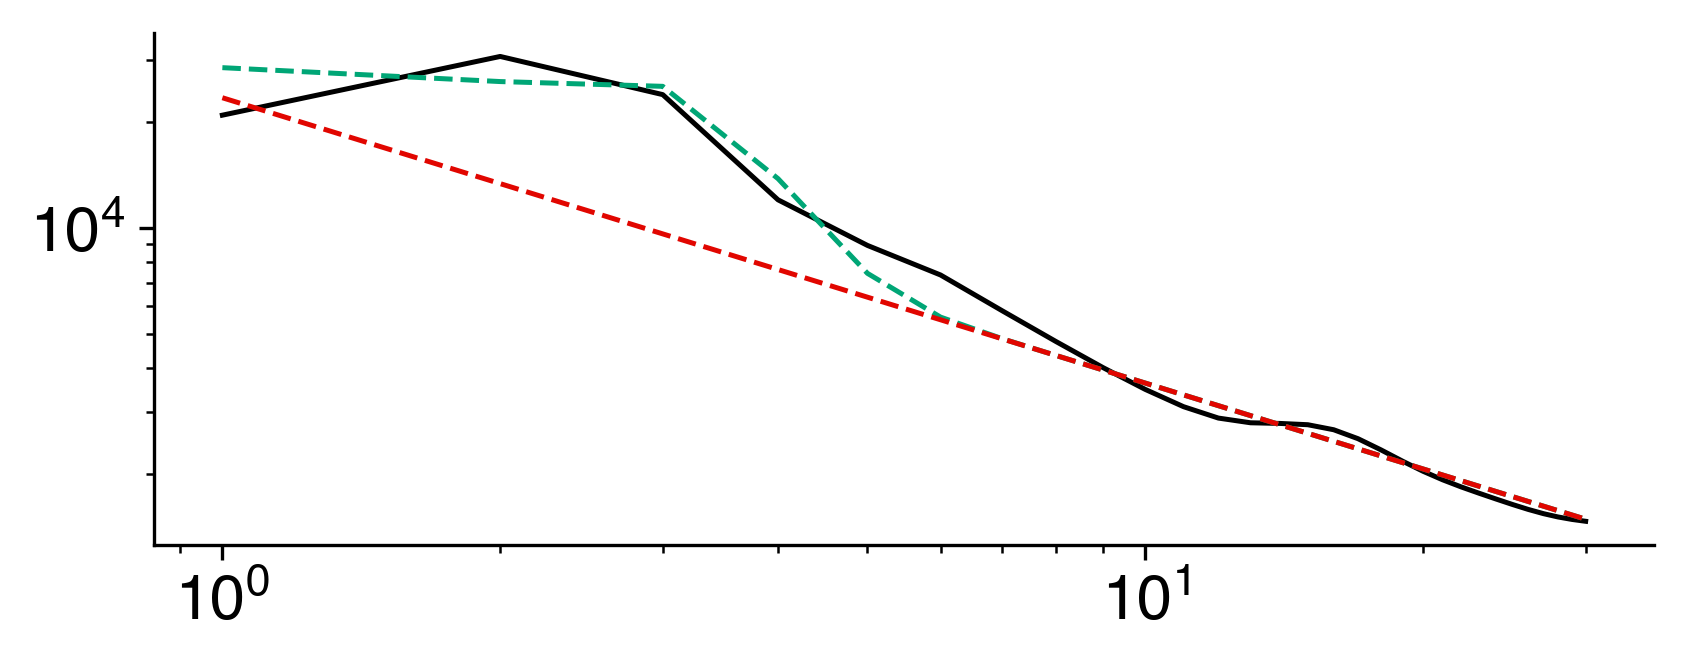

In [171]:
iSpec = 12

plt.close()
foof = fg.get_fooof(iSpec)
print(fg.group_results[iSpec].peak_params)
plt.plot(freqs, np.swapaxes(mean_power.values, 0, 1).reshape((np.prod(mean_power.shape[:2]), mean_power.shape[2]))[iSpec, :freqs.size], color='k', lw=1.2, alpha=1)
# plt.plot(freqs, mean_power.values[5, 0, :], color='k', lw=1.2, alpha=1)
plt.plot(freqs, 10**foof.fooofed_spectrum_, color=colors['g'], ls='--', lw=1.2)
plt.plot(freqs, 10**foof._ap_fit, color=colors['r'], ls='--', lw=1.2)
plt.xscale('log')
plt.yscale('log')
plt.show()

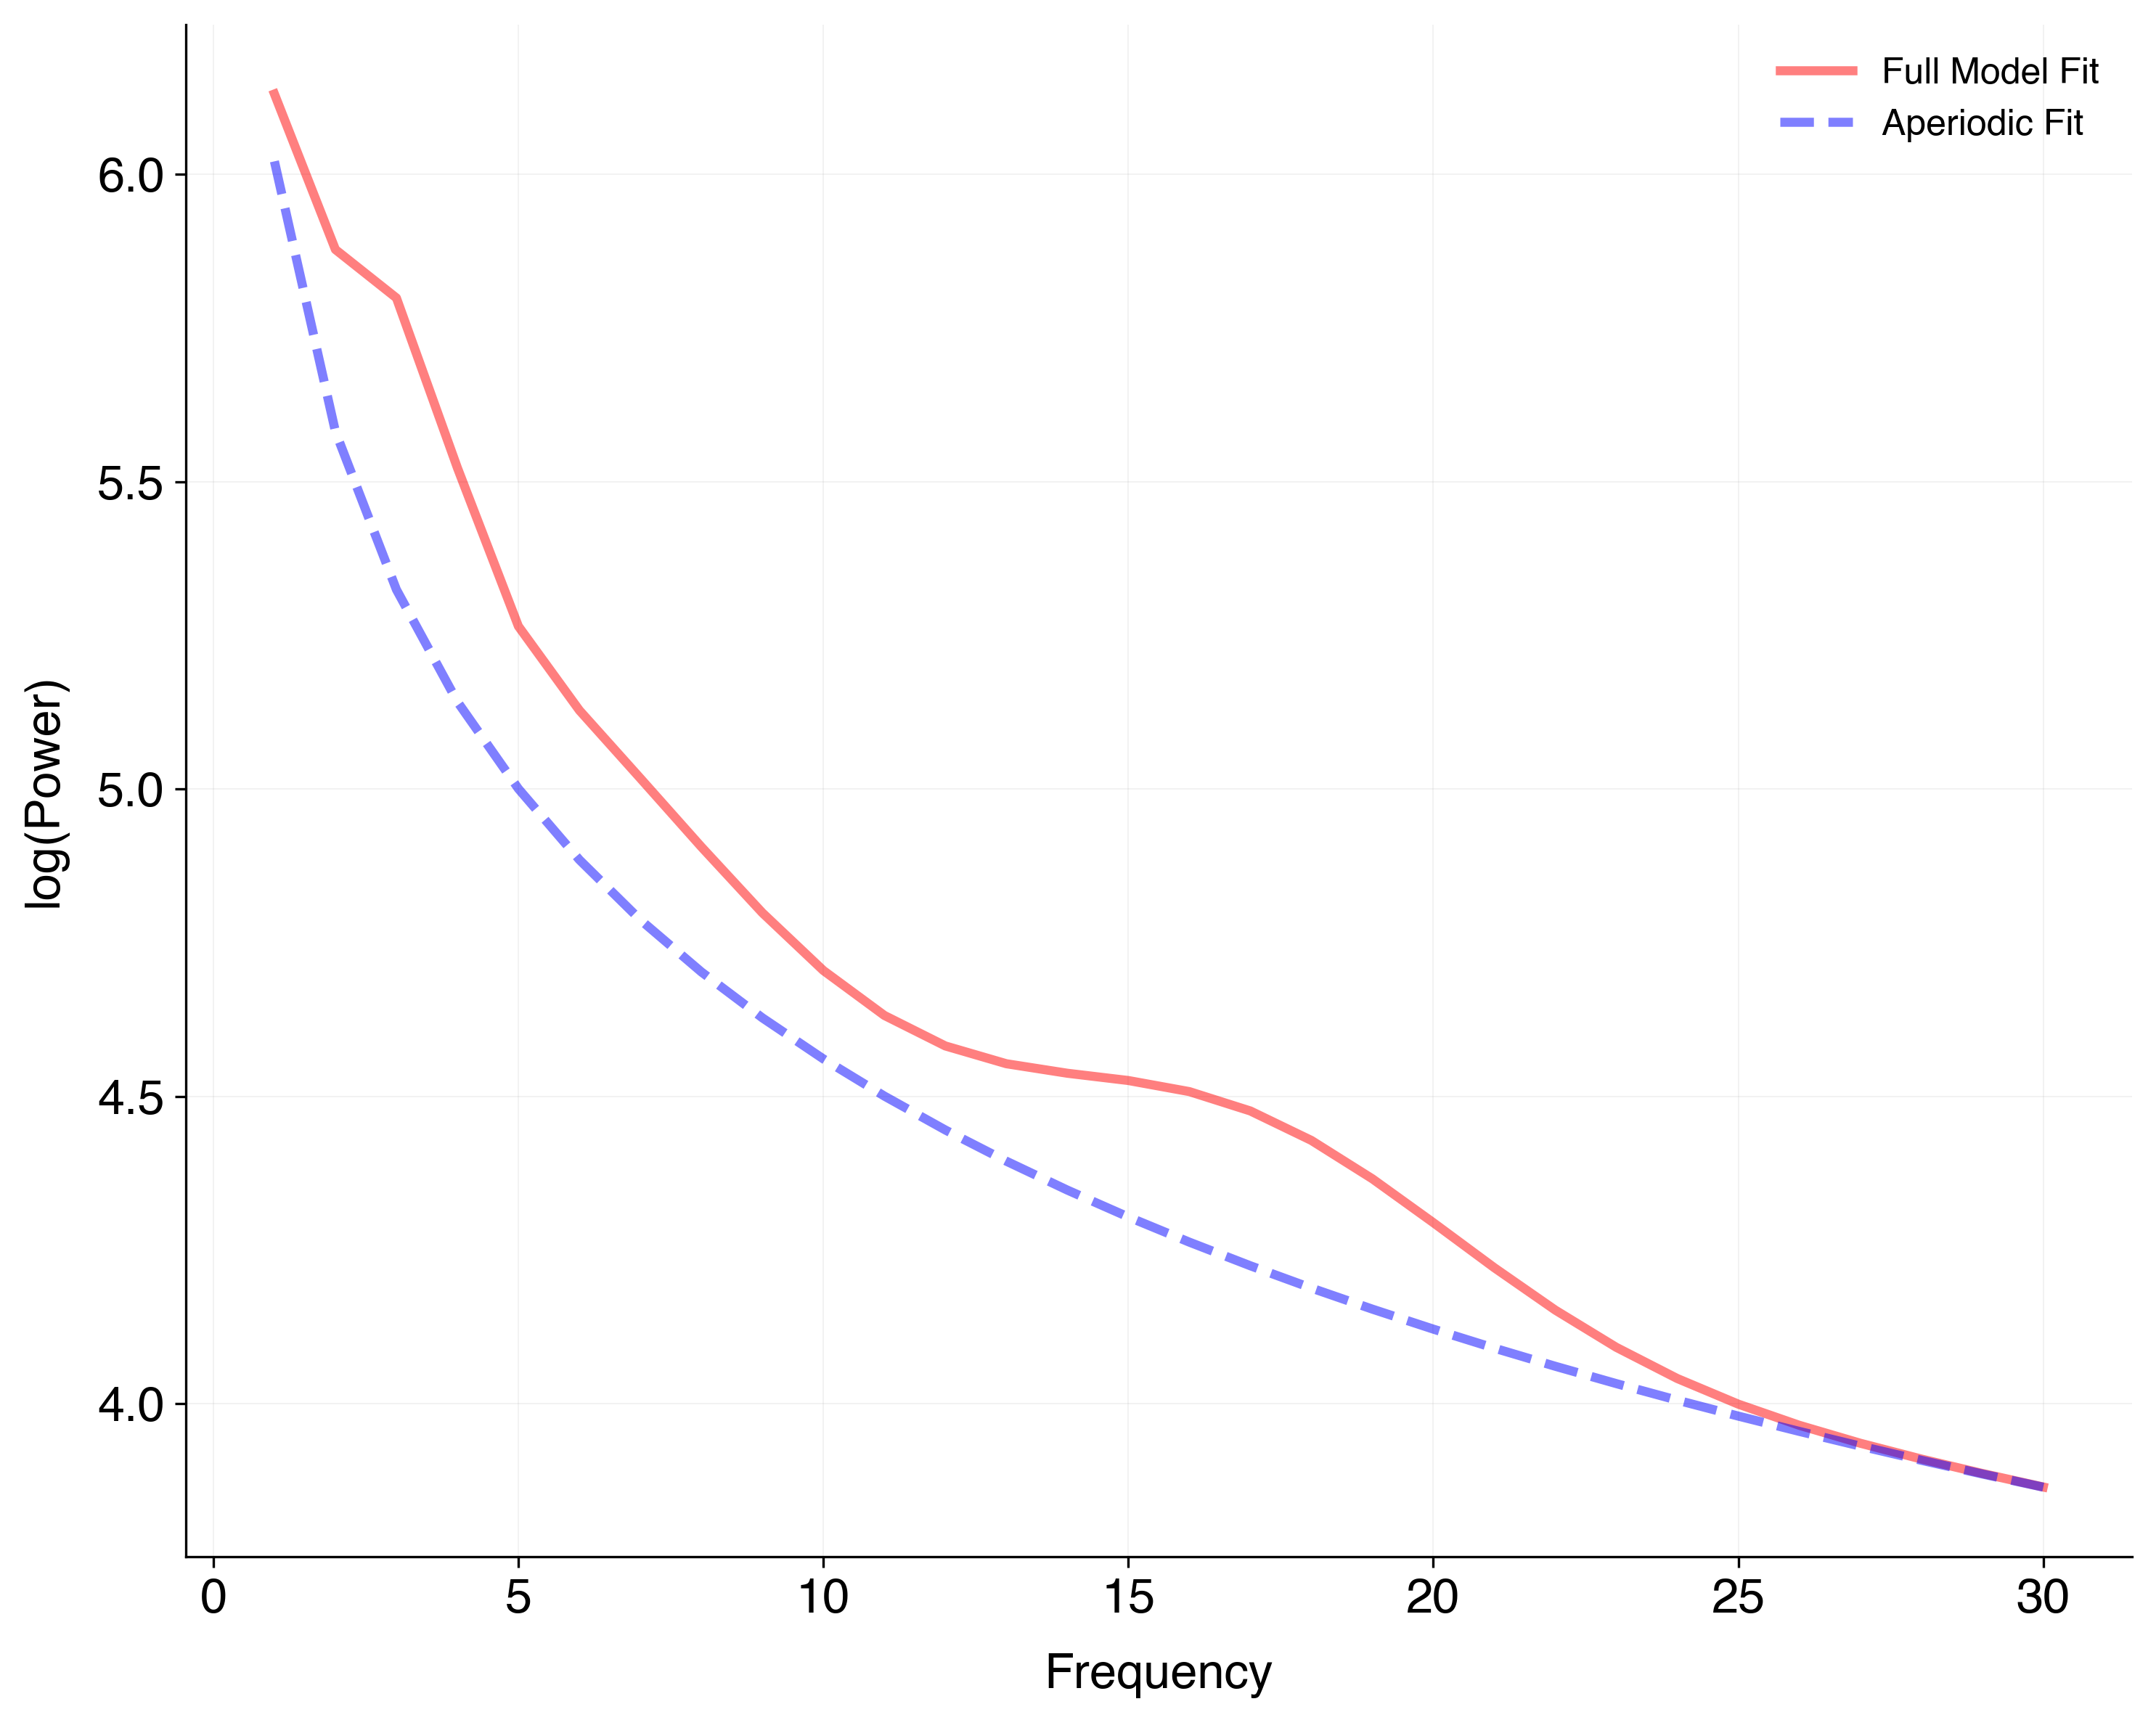

In [172]:
bands = Bands({'delta': (1, 4),
               'theta': (4, 10),
               'alpha/beta': (10, 30)})
afm = average_fg(fg, bands=bands, avg_method='median')
afm.plot()

# P-episode

In [43]:
subj_sess = 'U530_ses0'
roi = 'RMH'
sr = 1000
buffer = 0
chan_exclusion_thresh = 2
verbose = True
freqs = np.arange(1, 31).astype(int)

regions = [roi]
event_eeg = eeg_preproc.load_event_eeg(subj_sess,
                                       regions=regions,
                                       buffer=buffer,
                                       chan_exclusion_thresh=chan_exclusion_thresh,
                                       verbose=verbose)
event_eeg = event_eeg[roi].stack(event=('gameState', 'trial')).transpose('event', 'chan', 'time')

print('{}: {}'.format(roi, event_eeg.shape))

U530_ses0
---------
Kept 8/8 (100%) channels across 1 regions
Ran in 4.4s

RMH: (72, 8, 30000)


In [45]:
timer = Timer()

# Load spectral decomp.
output_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/spectral'
power, phase = spectral_analysis.timefreq_wavelet(event_eeg,
                                                  freqs,
                                                  output_dir=output_dir)
print('power: {}, phase: {}'.format(power.shape, phase.shape),
      'dims = {}'.format(power.dims), sep='\n')

print(timer)

power: (72, 8, 30, 30000), phase: (72, 8, 30, 30000)
dims = ('event', 'chan', 'freq', 'time')
Ran in 6.7s


In [47]:
# Load oscillation mask.
output_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/p_episode'
save_output = False
overwrite = False
timer = Timer()
osc_mask = spectral_analysis.run_p_episode(subj_sess,
                                           roi,
                                           output_dir=output_dir,
                                           save_output=save_output,
                                           overwrite=overwrite,
                                           verbose=verbose)

# Load FOOOF.
output_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/fooof'
fg = spectral_analysis.run_fooof(subj_sess,
                                 roi,
                                 output_dir=output_dir)
print(timer)

Ran in 0.4s


In [50]:
pd.Series(data=np.round(np.mean(osc_mask.values, axis=(0, 1, 3)) * 100, 1),
          index=freqs)

1      0.1
2      4.9
3      8.3
4     11.1
5     31.4
6     45.3
7     42.9
8     31.2
9     22.0
10    13.7
11     8.4
12     4.6
13     2.9
14     2.1
15     1.7
16     1.3
17     0.9
18     0.7
19     0.5
20     0.5
21     0.5
22     0.5
23     0.4
24     0.4
25     0.5
26     0.4
27     0.5
28     0.5
29     0.5
30     0.5
dtype: float64

In [198]:
power.name

('U530_ses0', 'RMH')

In [175]:
# Get the average power at each frequency over time, for each channel and event.
if power.clip_buffer:
    mean_power = power.mean(dim='time') # event x chan x freq
else:
    mean_power = power[:, :, :, power.buffer:power.time.size-power.buffer].mean(dim='time')

In [195]:
power.clip_buffer#values[:, iChan, :, power.buffer:power.time.size-power.buffer].shape

True

In [191]:
mean_power = np.nanmean(power.values[:, iChan, :, :], axis=(0, 2)) # (freq,)


array([37885516.   , 26145534.   , 15863741.   , 10957373.   ,
       12463900.   , 12709299.   ,  9283663.   ,  5814993.5  ,
        3531448.   ,  2207830.   ,  1465707.   ,  1043785.3  ,
         789990.4  ,   623948.4  ,   507009.6  ,   421093.06 ,
         356706.4  ,   307839.75 ,   270201.4  ,   240623.66 ,
         216807.77 ,   197145.66 ,   180546.22 ,   166270.95 ,
         153806.11 ,   142781.28 ,   132923.34 ,   124030.164,
         115951.71 ,   108575.625], dtype=float32)

In [218]:
np.mean(np.mean(power.values[:, iChan, :, :], axis=-1), axis=0)

array([37885520.   , 26145532.   , 15863751.   , 10957374.   ,
       12463904.   , 12709296.   ,  9283660.   ,  5814991.5  ,
        3531448.2  ,  2207829.8  ,  1465707.   ,  1043785.9  ,
         789990.4  ,   623948.   ,   507009.38 ,   421093.1  ,
         356706.44 ,   307839.7  ,   270201.38 ,   240623.67 ,
         216807.88 ,   197145.64 ,   180546.12 ,   166270.92 ,
         153806.16 ,   142781.31 ,   132923.36 ,   124030.16 ,
         115951.664,   108575.63 ], dtype=float32)

In [223]:
np.mean(np.log10(power.values[:, iChan, :, :]), axis=-1)

array([[7.3715544, 7.091596 , 6.7891593, ..., 4.827906 , 4.80382  ,
        4.7775536],
       [7.3399334, 7.0798182, 6.6871104, ..., 4.775249 , 4.742247 ,
        4.7061033],
       [7.1987877, 7.265281 , 6.9484053, ..., 4.827936 , 4.793471 ,
        4.765218 ],
       ...,
       [7.2956557, 7.157424 , 6.952031 , ..., 4.8667235, 4.840221 ,
        4.814906 ],
       [7.376204 , 7.2737603, 6.850455 , ..., 4.8128824, 4.7875276,
        4.763366 ],
       [7.231618 , 7.2338676, 6.9364347, ..., 4.828638 , 4.7978024,
        4.768408 ]], dtype=float32)

In [221]:
stats.sem(np.mean(np.log10(power.values[:, iChan, :, :]), axis=-1), axis=0)

array([0.01624271, 0.01043047, 0.00947431, 0.01059514, 0.01089731,
       0.00935999, 0.0094873 , 0.00991958, 0.00956755, 0.008226  ,
       0.00715745, 0.00657335, 0.00604541, 0.00568601, 0.00532927,
       0.00502934, 0.00484418, 0.00468244, 0.00447685, 0.00408694,
       0.00368531, 0.00347907, 0.00339343, 0.00328472, 0.00328673,
       0.00334444, 0.00342643, 0.00348292, 0.00345127, 0.00343922],
      dtype=float32)

In [209]:
mean_power, sem_power

(array([7.307685 , 7.1374493, 6.9108725, 6.728458 , 6.7855096, 6.793804 ,
        6.649608 , 6.4419928, 6.2340918, 6.045716 , 5.88176  , 5.744655 ,
        5.6304674, 5.5300956, 5.441819 , 5.360246 , 5.289197 , 5.227336 ,
        5.173526 , 5.1244526, 5.080432 , 5.0400987, 5.002185 , 4.966174 ,
        4.9325414, 4.9009733, 4.869701 , 4.8393025, 4.8098354, 4.780848 ],
       dtype=float32),
 array([0.01624271, 0.01043047, 0.00947431, 0.01059514, 0.01089731,
        0.00935999, 0.0094873 , 0.00991958, 0.00956755, 0.008226  ,
        0.00715745, 0.00657335, 0.00604541, 0.00568601, 0.00532927,
        0.00502934, 0.00484418, 0.00468244, 0.00447685, 0.00408694,
        0.00368531, 0.00347907, 0.00339343, 0.00328472, 0.00328673,
        0.00334444, 0.00342643, 0.00348292, 0.00345127, 0.00343922],
       dtype=float32))

In [213]:
np.mean(np.nanmean(np.log10(power.values[:, iChan, :, :]), axis=2), axis=0)

array([7.307686 , 7.137447 , 6.9108725, 6.728457 , 6.7855096, 6.7938046,
       6.649606 , 6.4419904, 6.2340918, 6.0457172, 5.88176  , 5.7446585,
       5.6304665, 5.5300927, 5.4418216, 5.3602495, 5.2891965, 5.2273364,
       5.1735244, 5.1244526, 5.080432 , 5.040099 , 5.002183 , 4.966175 ,
       4.932543 , 4.9009733, 4.869702 , 4.839303 , 4.809836 , 4.78085  ],
      dtype=float32)

In [214]:
stats.sem(np.nanmean(np.log10(power.values[:, iChan, :, :]), axis=2), axis=0)

array([0.01624271, 0.01043047, 0.00947431, 0.01059514, 0.01089731,
       0.00935999, 0.0094873 , 0.00991958, 0.00956755, 0.008226  ,
       0.00715745, 0.00657335, 0.00604541, 0.00568601, 0.00532927,
       0.00502934, 0.00484418, 0.00468244, 0.00447685, 0.00408694,
       0.00368531, 0.00347907, 0.00339343, 0.00328472, 0.00328673,
       0.00334444, 0.00342643, 0.00348292, 0.00345127, 0.00343922],
      dtype=float32)

[[7.21889359 0.72802992 5.27633143]]


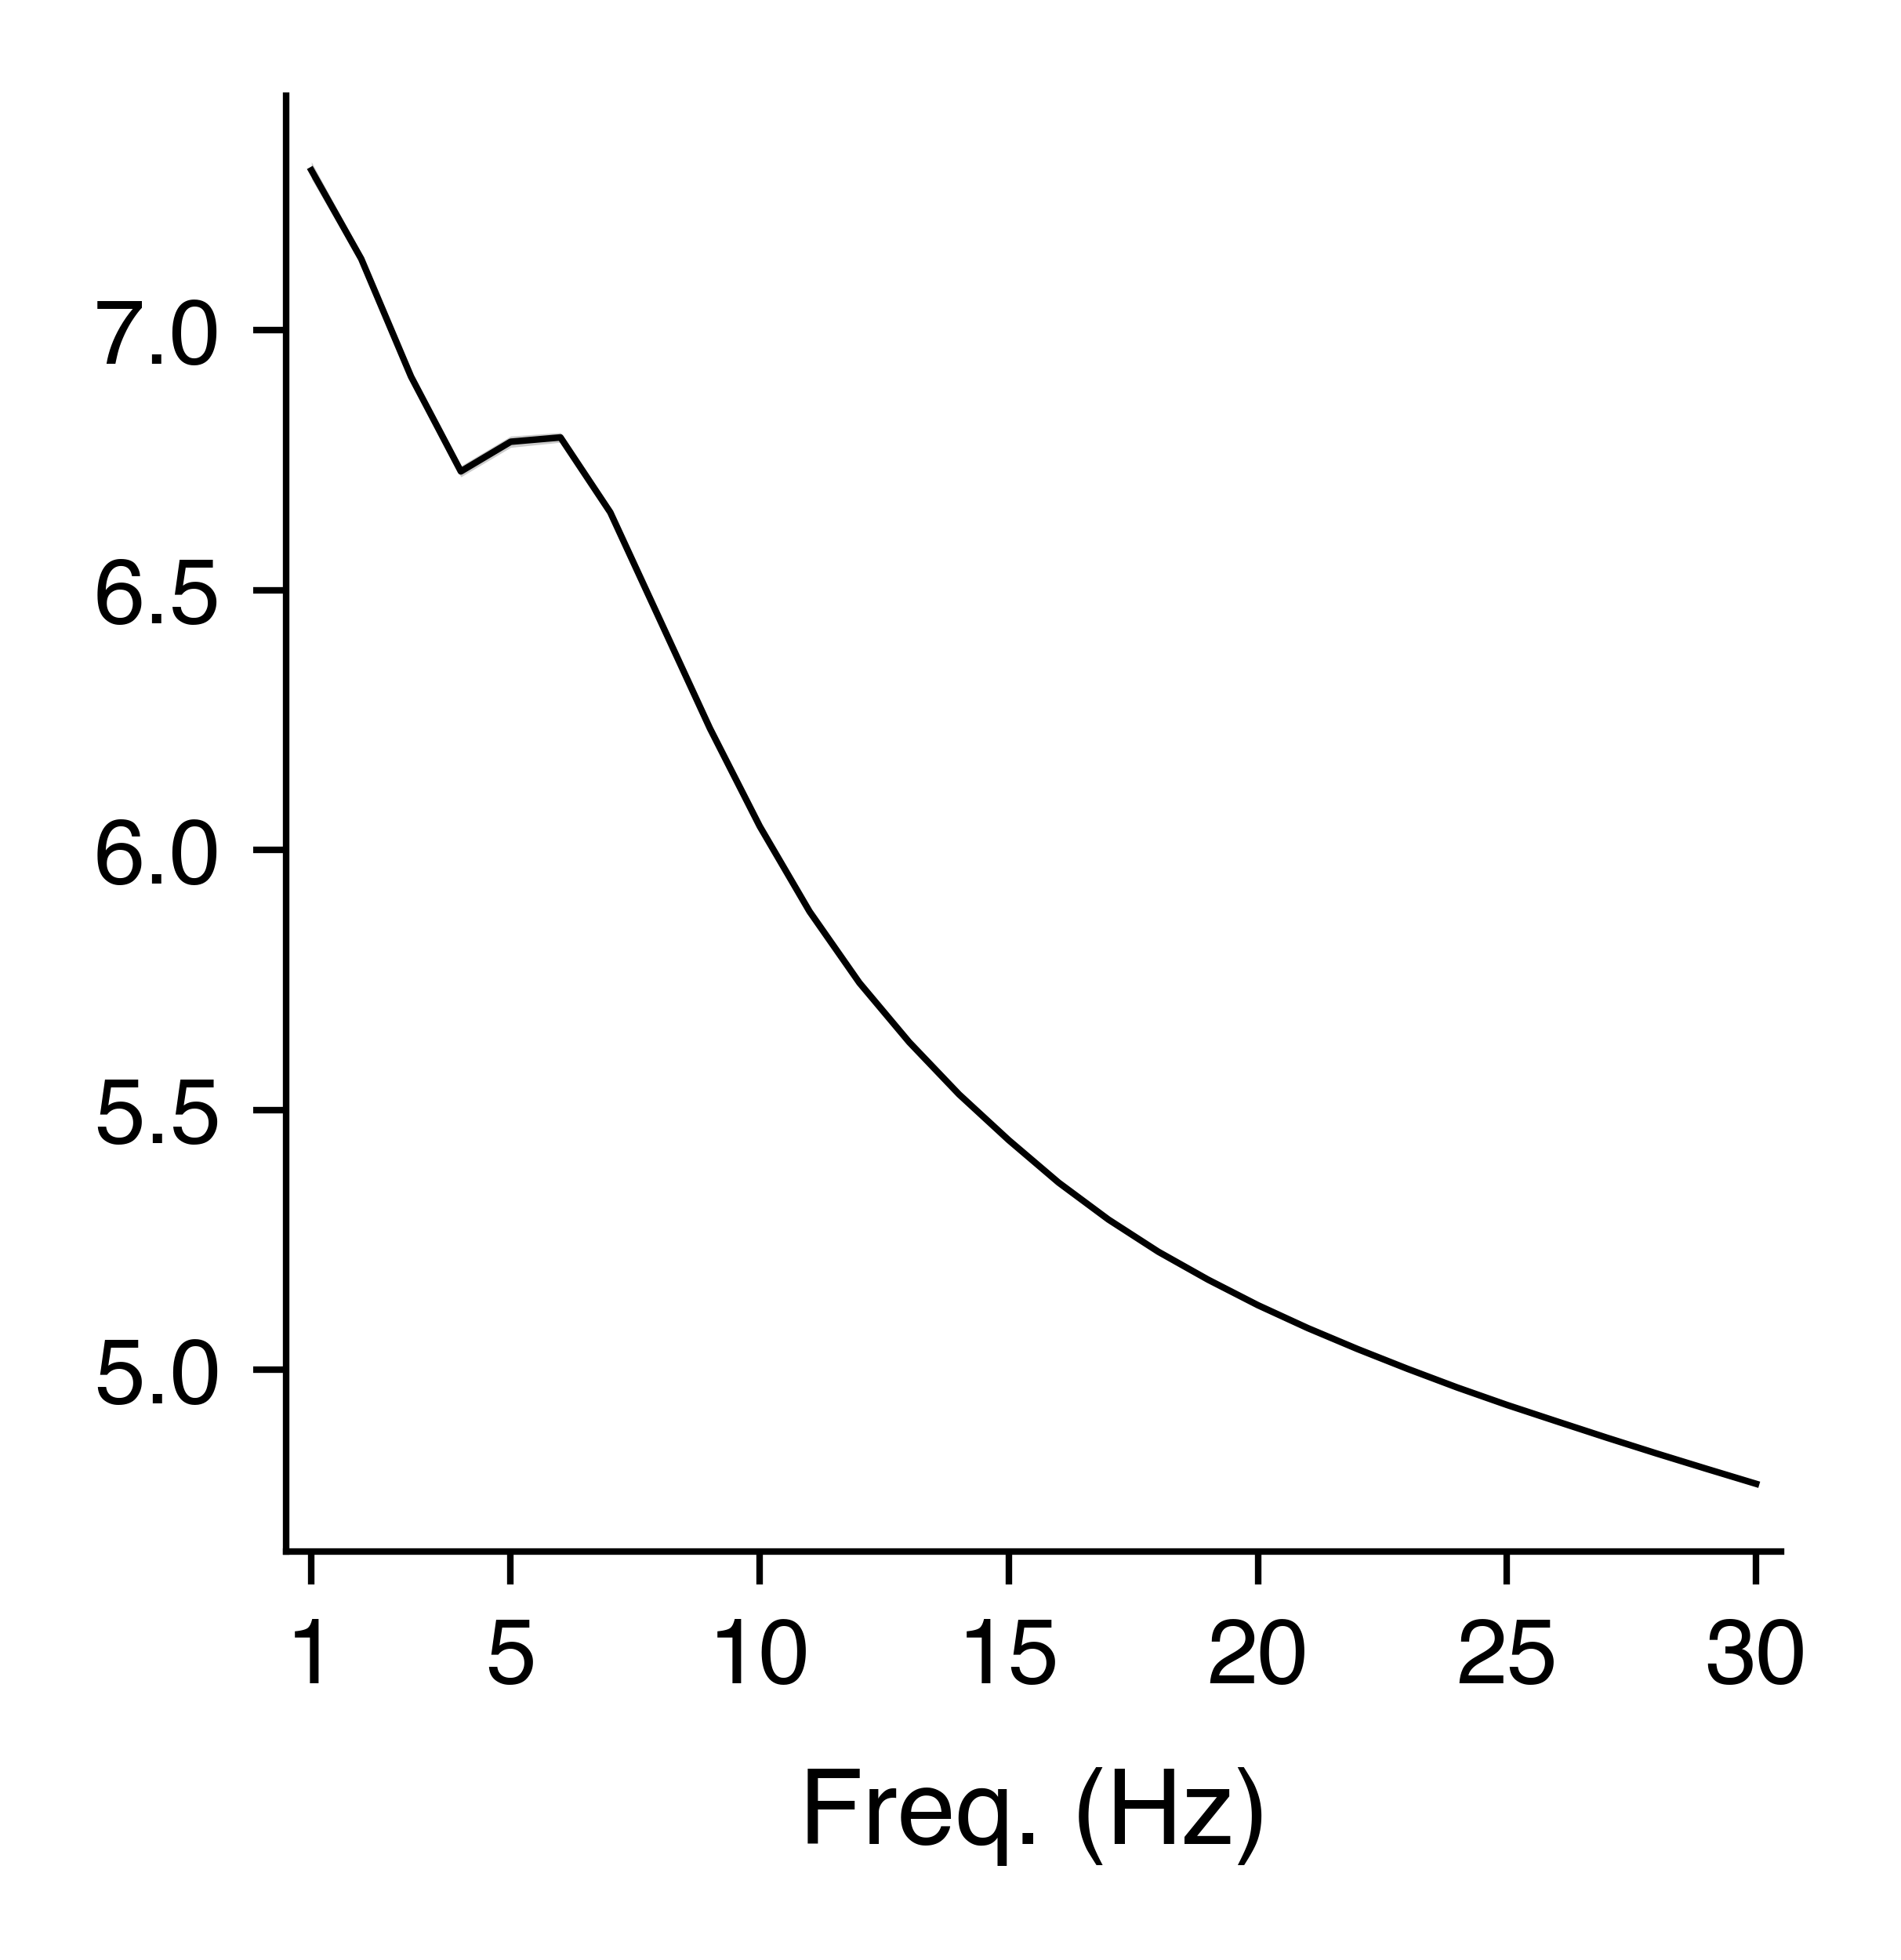

In [206]:
iEvent = 16
iChan = 4
figsize = (colws[1], colws[1])
dpi = 1200
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
linecolor = 'k'
xlim = [0.5, 30.5]
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
linewidth = 0.5
ax_linewidth = 0.5
tickpad = 2.5
ticklen = 2.5
labelpad = 5
savefig = False
overwrite = False

# ------------------
iSpec = (iChan * event_eeg.event.size) + iEvent
if power.clip_buffer:
    mean_power = np.nanmean(np.log10(power.values[:, iChan, :, :]), axis=(0, 2)) # (freq,)
    sem_power = stats.sem(np.nanmean(np.log10(power.values[:, iChan, :, :]), axis=2), axis=0) # (freq,)
else:
    mean_power = np.nanmean(np.log10(power.values[:, iChan, :, power.buffer:power.time.size-power.buffer]), axis=(0, 2)) # (freq,)
    sem_power = stats.sem(np.nanmean(np.log10(power.values[:, iChan, :, power.buffer:power.time.size-power.buffer]), axis=2), axis=0) # (freq,)

foof = fg.get_fooof(iSpec)
print(fg.group_results[iSpec].peak_params)

plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.fill_between(freqs,
                 mean_power + sem_power,
                 mean_power - sem_power,
                 alpha=0.2, lw=0, color=linecolor)
_ax.plot(freqs, mean_power, color=linecolor, lw=linewidth, alpha=1)
# plt.plot(freqs, _power, color='k', lw=1.2, alpha=1)
# plt.plot(freqs, _power.values[5, 0, :], color='k', lw=1.2, alpha=1)
# plt.plot(freqs, 10**foof.fooofed_spectrum_, color=colors['g'], ls='--', lw=1.2)
# plt.plot(freqs, 10**foof._ap_fit, color=colors['r'], ls='--', lw=1.2)
# plt.xscale('log')
# plt.yscale('log')

for spine in ['left', 'bottom']:
    _ax.spines[spine].set_linewidth(ax_linewidth)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=ax_linewidth)
_ax.set_xlim(xlim)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticks, fontsize=font['tick'])
_ax.set_xlabel('Freq. (Hz)', fontsize=font['label'], labelpad=labelpad)

fig.show()

[[7.21889359 0.72802992 5.27633143]]


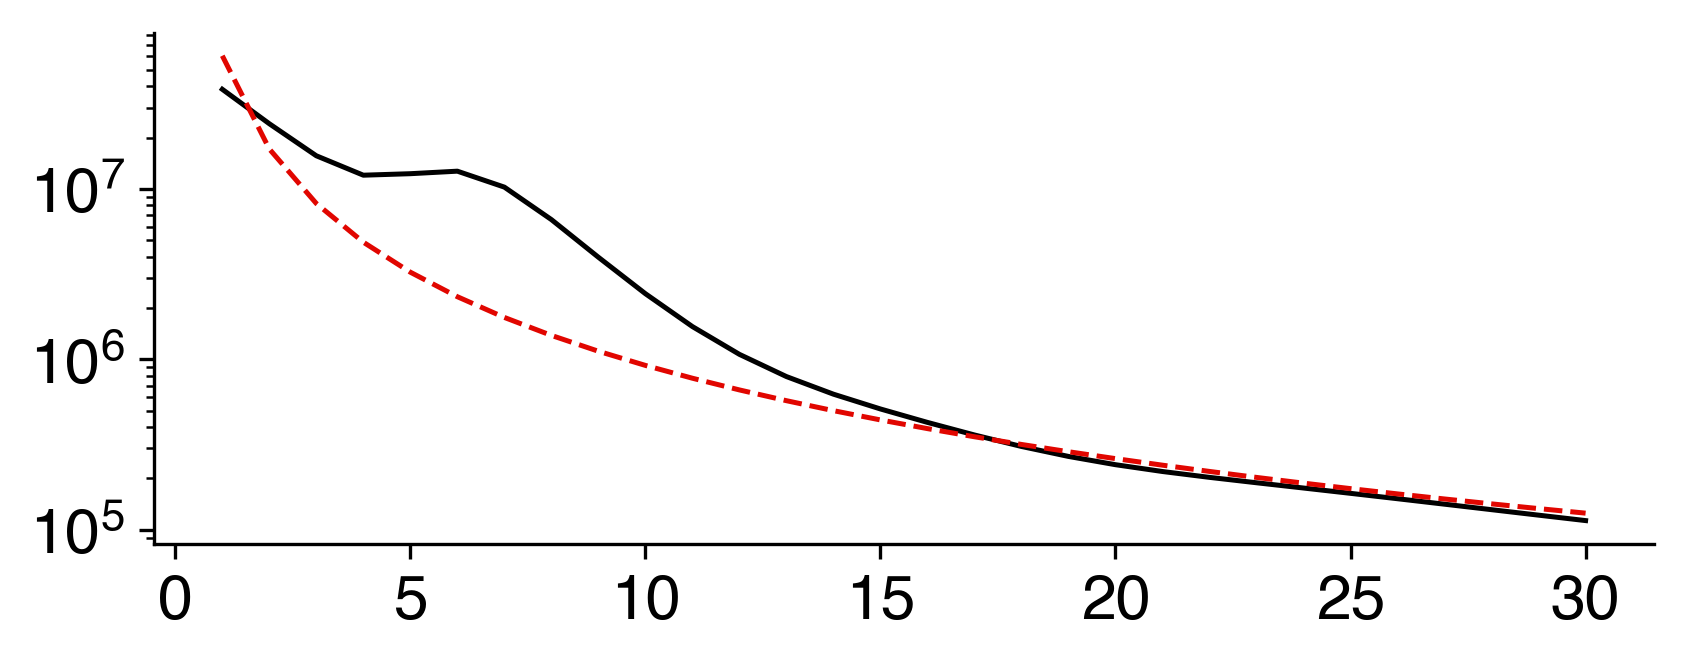

In [186]:
iEvent = 16
iChan = 4

# ------------------
iSpec = (iChan * event_eeg.event.size) + iEvent
if power.clip_buffer:
    mean_power = power.mean(dim='time') # event x chan x freq
else:
    mean_power = power[:, :, :, power.buffer:power.time.size-power.buffer].mean(dim='time')

plt.close()
foof = fg.get_fooof(iSpec)
print(fg.group_results[iSpec].peak_params)
plt.plot(freqs, np.swapaxes(mean_power.values, 0, 1).reshape((np.prod(mean_power.shape[:2]), mean_power.shape[2]))[iSpec, :freqs.size], color='k', lw=1.2, alpha=1)
# plt.plot(freqs, _power, color='k', lw=1.2, alpha=1)
# plt.plot(freqs, _power.values[5, 0, :], color='k', lw=1.2, alpha=1)
# plt.plot(freqs, 10**foof.fooofed_spectrum_, color=colors['g'], ls='--', lw=1.2)
plt.plot(freqs, 10**foof._ap_fit, color=colors['r'], ls='--', lw=1.2)
# plt.xscale('log')
plt.yscale('log')
plt.show()

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/lfp_traces/lfp-U530_ses0-RMH-CSC13-trial15-Encoding-filt6Hz.pdf


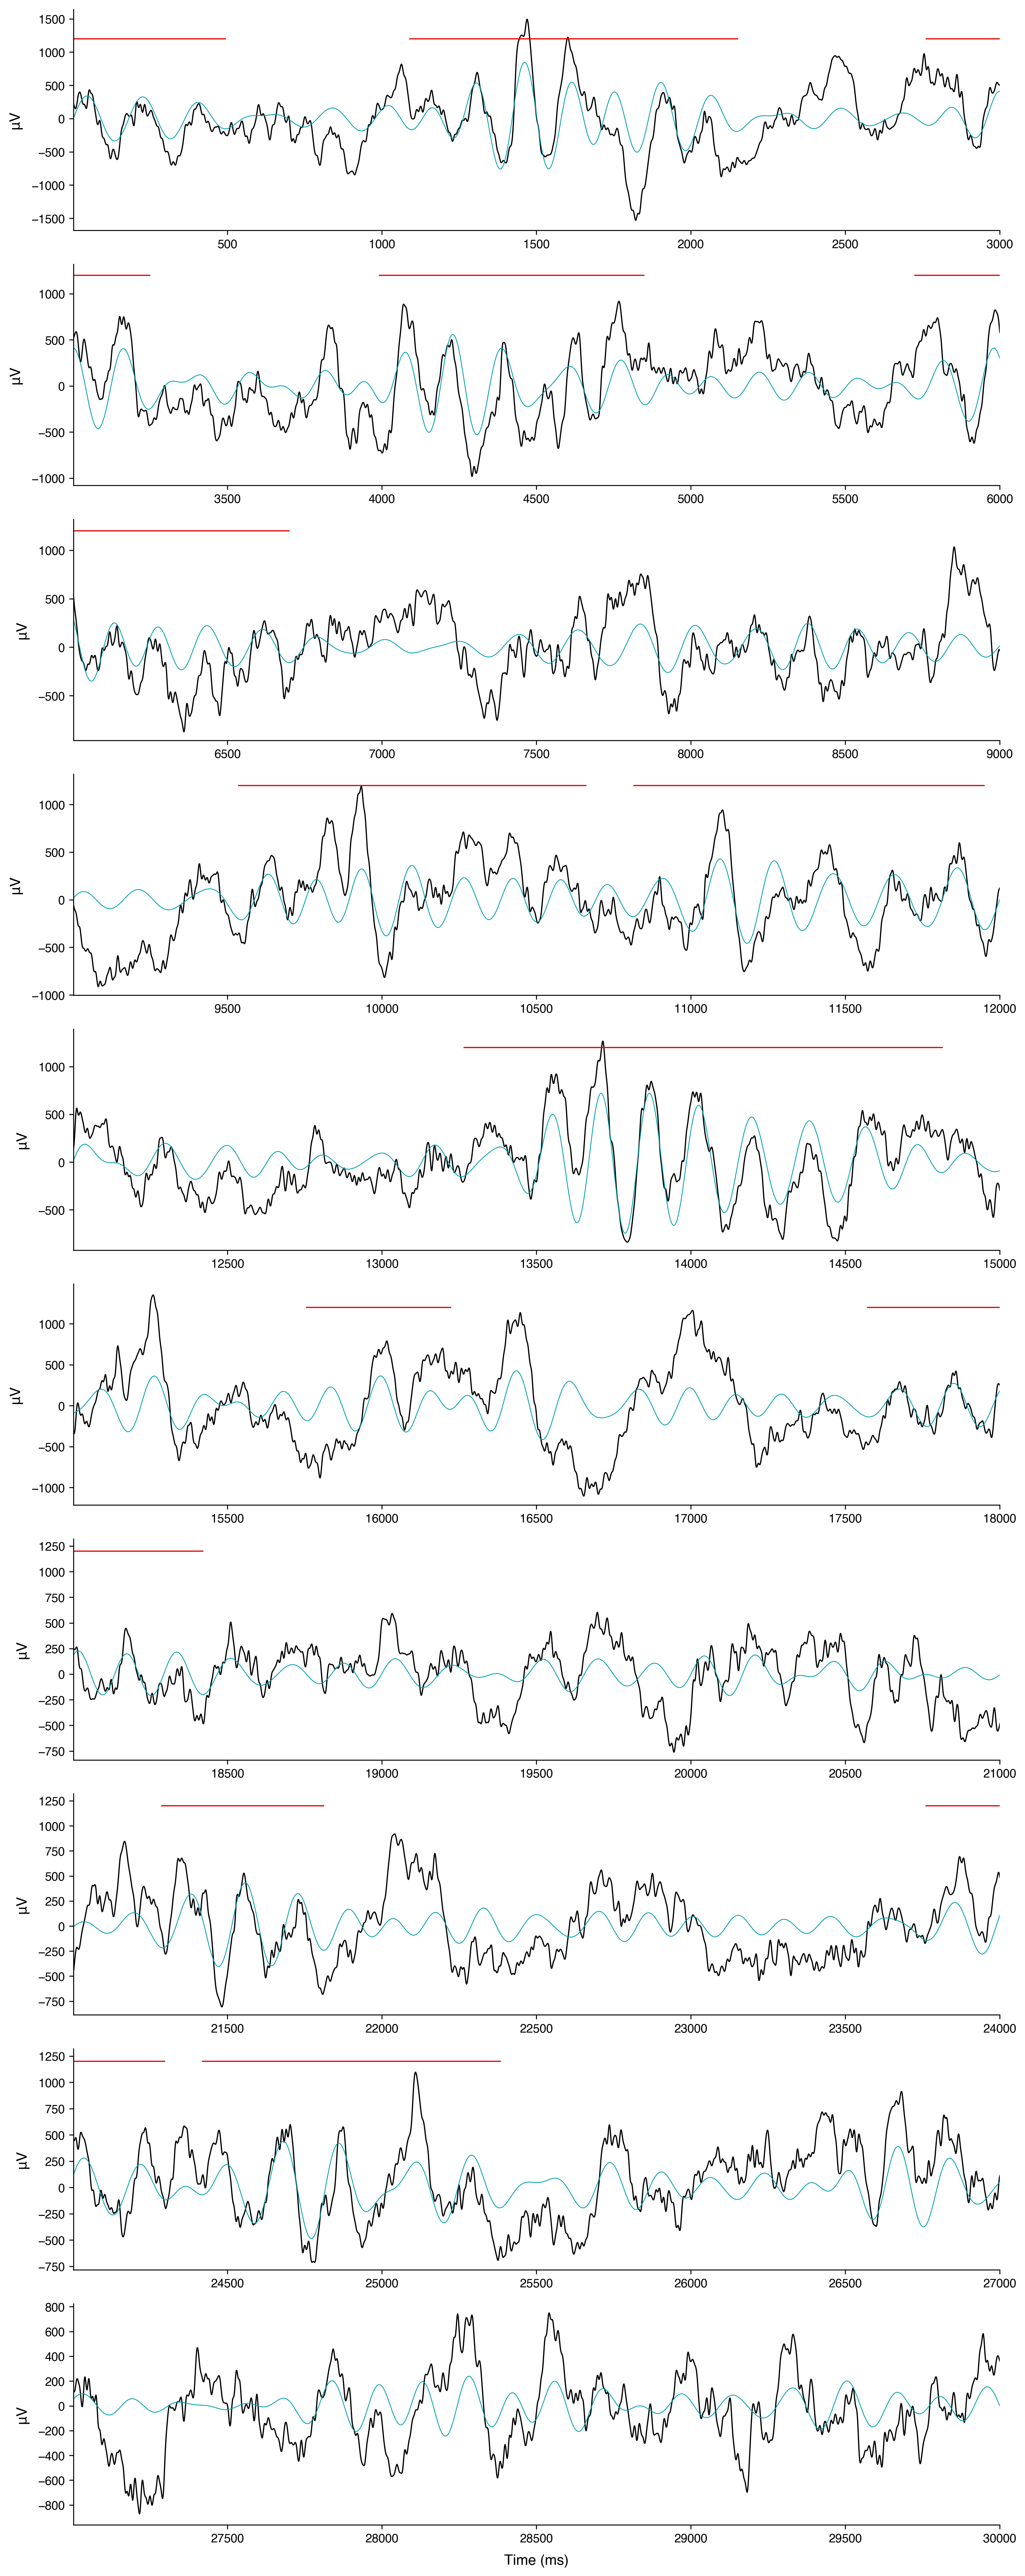

In [155]:
iEvent = 14
iChan = 4
iFreq = 5
mask_val = 1200
linecolors = ['k', colors['t'], colors['r']]
linewidths = [1, 0.67, 1]
alphas = [1, 1, 1]
dpi = 600
savefig = True
overwrite = False
output_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/figs2/lfp_traces'
# palette = 'viridis'
# linecolors = sns.color_palette(palette=palette, n_colors=event_eeg.shape[1])

# --------------------
nsamp = event_eeg.shape[-1]
buffer = event_eeg.buffer
sr = event_eeg.sr
_osc_mask = mask_val * osc_mask.astype(float)[iEvent, iChan, iFreq, buffer:nsamp-buffer]
_osc_mask[_osc_mask==0] = np.nan
dat = np.vstack((event_eeg.values[iEvent, iChan, buffer:nsamp-buffer],
                 mne.filter.filter_data(event_eeg.values[iEvent, iChan, buffer:nsamp-buffer],
                                        sr, l_freq=freqs[iFreq]*0.9, h_freq=freqs[iFreq]*1.1,
                                        verbose=False),
                 _osc_mask))

plt.close()
fig, ax = plot_trace(dat, start=0, duration=30000, x_units='ms', sampling_rate=sr, nwin=10, figsize=(12, 30),
                     colors=linecolors, linewidths=linewidths, alphas=alphas,
                     sub_mean=False, same_yaxis=False, conv_to_muv=False, create_spread=False)

if savefig:
    filename = op.join(output_dir,
                       'lfp-{}-{}-CSC{}-trial{}-{}-filt{}Hz.pdf'
                       .format(event_eeg.name[0],
                               event_eeg.name[1],
                               int(event_eeg.chan[iChan]),
                               event_eeg.event[[iEvent]].values[0][1],
                               event_eeg.event[[iEvent]].values[0][0],
                               freqs[iFreq]))
    if overwrite or not op.exists(filename):
        print('Saved {}'.format(filename))
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)

In [156]:
iEvent = 12
iChan = 0
iFreq = 6

# -------------------------
buffer = event_eeg.buffer
sr = event_eeg.sr
if len(event_eeg.dims) == 4:
    event_eeg = event_eeg.stack(event=('gameState', 'trial')).transpose('event', 'chan', 'time')
_means = np.mean(power.values, axis=(0, 1, 3))
_stds = np.std(power.values, axis=(0, 1, 3))
_osc_mask = 3.5 * osc_mask.astype(float)[iEvent, iChan, iFreq, buffer:osc_mask.shape[-1]-buffer]
_osc_mask[_osc_mask==0] = np.nan

dat = np.vstack((stats.zscore(event_eeg.values[iEvent, iChan, buffer:event_eeg.shape[-1]-buffer]),
                 stats.zscore(mne.filter.filter_data(event_eeg.values[iEvent, iChan, buffer:event_eeg.shape[-1]-buffer],
                                                     event_eeg.sr, l_freq=freqs[iFreq]*0.9, h_freq=freqs[iFreq]*1.1, verbose=False)),
                 stats.zscore(np.log10(power.values), axis=(0, 3))[iEvent, iChan, iFreq, buffer:power.shape[-1]-buffer],
                 phase.values[iEvent, iChan, iFreq, buffer:phase.shape[-1]-buffer]-np.pi,
                 _osc_mask))

linecolors = ['k', colors['t'], colors['p'], colors['y'], colors['r']]
linewidths = [1, 0.75, 0.75, 0.75, 1]
alphas = [1, 0.67, 0, 0, 1]
plt.close()
fig, ax = plot_trace(dat, start=0, duration=30000, x_units='ms',
                     sampling_rate=sr, nwin=10, figsize=(12, 30),
                     colors=linecolors, alphas=alphas, linewidths=linewidths,
                     create_spread=False, sub_mean=False, conv_to_muv=False, same_yaxis=False)
# for _ax in ax:
#     _ax.axhline(np.percentile(zpower.values[:, :, :, iFreq, :], power_thresh), color='k', ls='--', lw=0.8)
#     _ax.axhline((ap_thresh[iEvent, iChan, iFreq] - _means[iFreq]) / _stds[iFreq], color='k', ls='--', lw=0.8)
#     _ax.set_ylim([-4, 4])
fig.show()

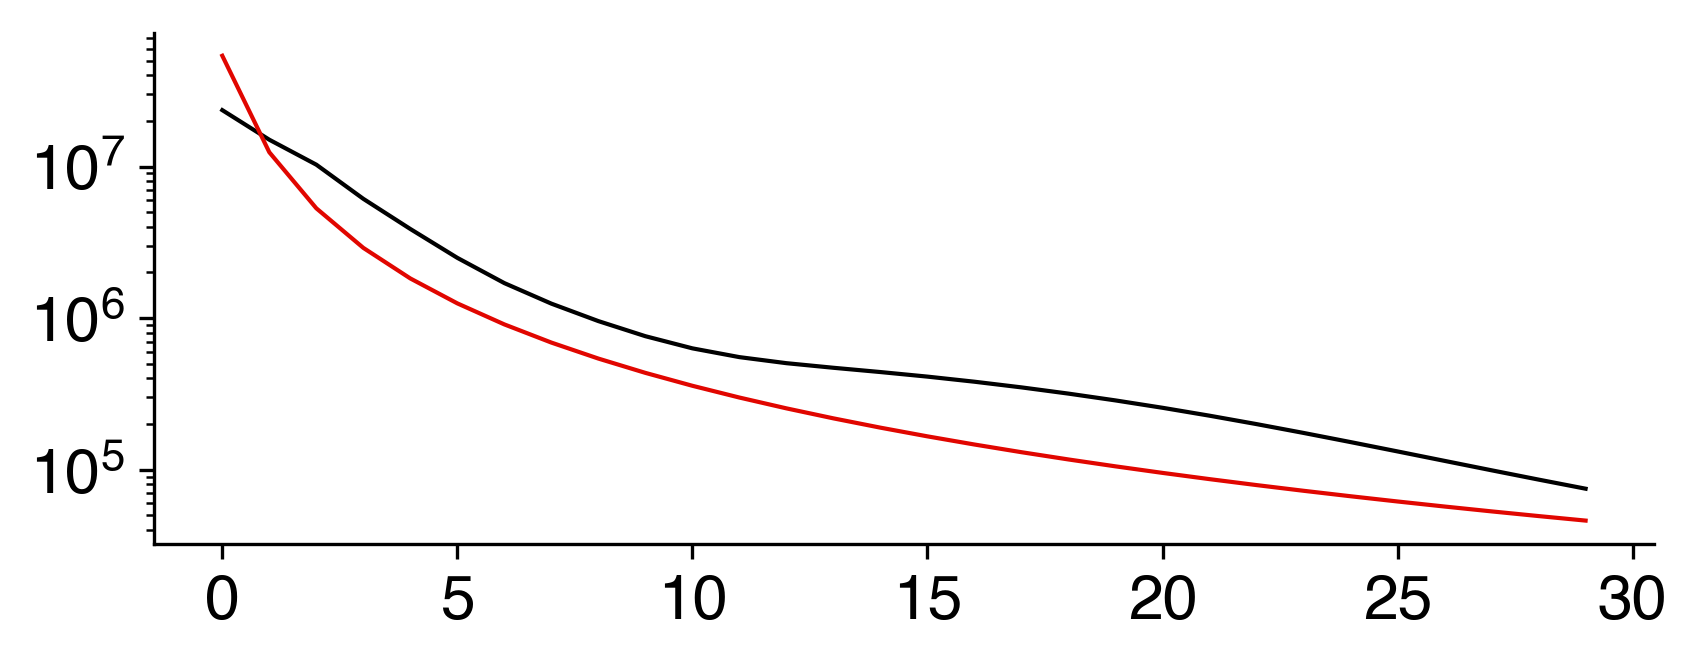

In [140]:
plt.close()
plt.plot(np.mean(power[:, :, :30, :], axis=(0, 1, 3)), color='k')
plt.plot(np.mean(ap_thresh[:, :, :30, :], axis=(0, 1, 3)), color=colors['r'])
plt.yscale('log')
plt.show()

In [1123]:
subj_sess = 'U530_ses1'
regions = ['LA']
time_eeg = load_time_eeg(subj_sess,
                         regions,
                         downsample_to=sr,
                         l_freq=l_freq,
                         h_freq=h_freq,
                         notch_freqs=notch_freqs,
                         chan_exclusion_thresh=0,
                         verbose=False)

In [ ]:
chan_exclusion_thresh = 2
time_eeg = load_time_eeg(subj_sess,
                         chan_exclusion_thresh=chan_exclusion_thresh,
                         verbose=True)

U530_ses1
---------
Excluded LMH channel 33 (index 0)
Excluded LOF channel 50 (index 1)
Excluded REC channel 1 (index 0)
Excluded RMH channel 13 (index 4)
Kept 92/768 (12%) channels across 12 regions
Ran in 62.7s



In [1148]:
subj_sess = 'U530_ses1'
regions = None
chan_exclusion_thresh = 0
event_eeg = load_event_eeg(subj_sess,
                           regions,
                           chan_exclusion_thresh=chan_exclusion_thresh,
                           verbose=True)

U530_ses1
---------
Kept 96/96 (100%) channels across 12 regions
Ran in 29.4s



U530_ses0
---------
Excluded LMH channel 33 (index 0)
Kept 7/8 (88%) channels across 1 regions
Ran in 5.3s



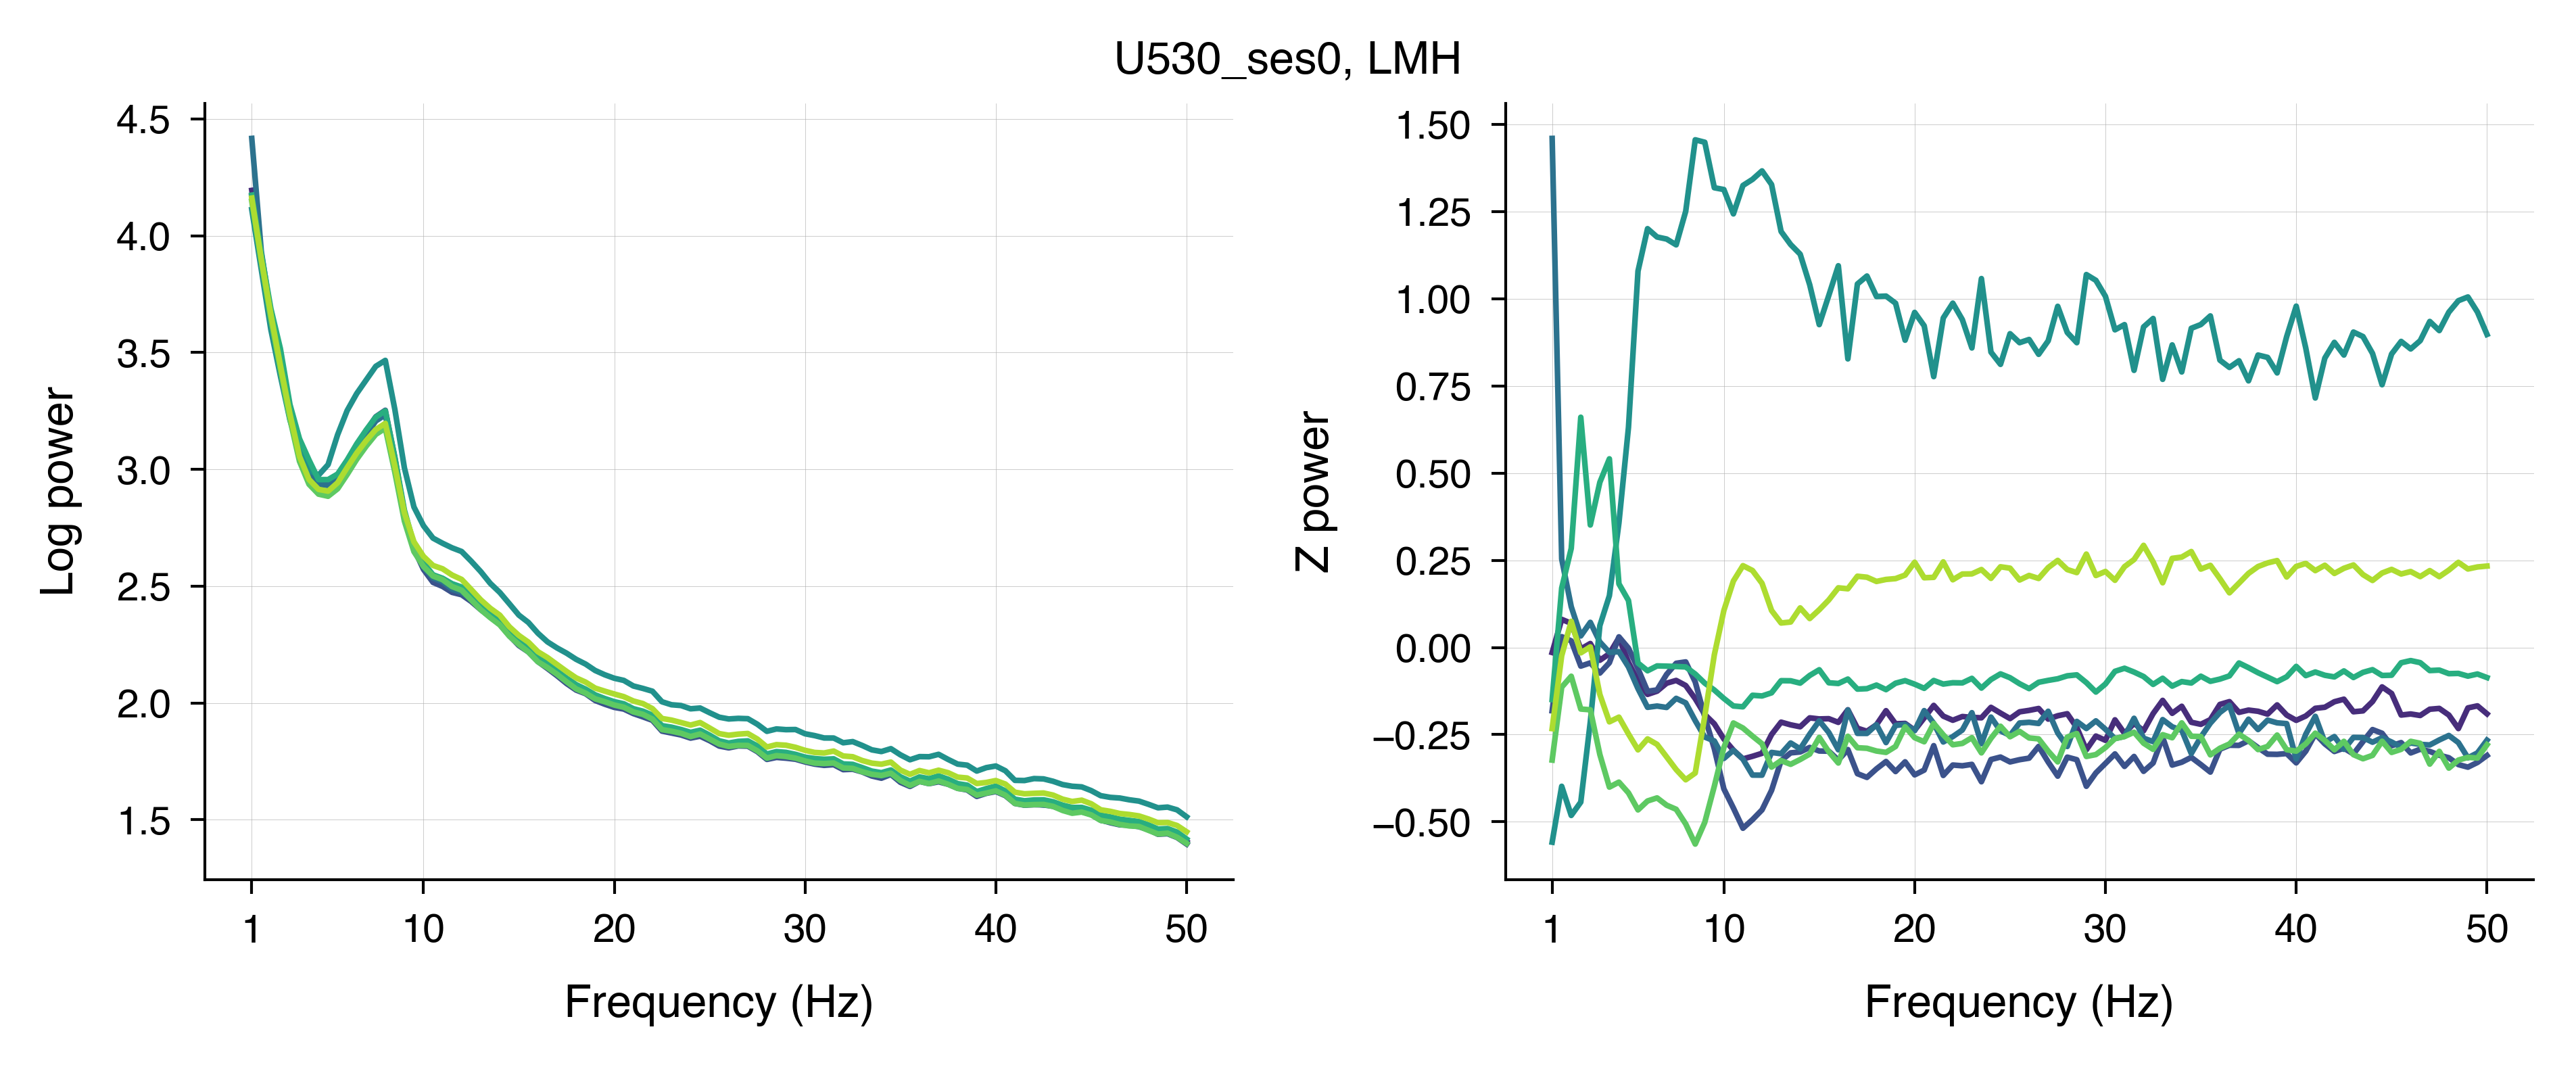

In [501]:
subj_sess = 'U530_ses0'
roi = 'LMH'

# EEG proc params.
game_states = ['Encoding', 'Retrieval']
buffer = 2500
l_freq = 0.1
h_freq = 80
notch_freqs = [60]
chan_exclusion_thresh = 2

# Power decomp params.
fmin = 0.5
fmax = 50
n_fft = int(sr * 2)
n_overlap = int(sr)

# Plot params.
savefig = False
overwrite = False
figsize = (colws[2], colws[2])
dpi = 600
linewidth = 0.5
font = {'tick': 7, 'label': 8, 'fig': 8, 'annot': 7}
ax_linewidth = 0.5
labelpad = 6
xticklabs = [1, 10, 20, 30, 40, 50]
ticklen = 2.5
tickwidth = 0.5
tickpad = 2.5
show_grid = True

# ---------------------
# Load EEG.
sr = 1000
event_eeg = load_event_eeg(subj_sess,
                           regions=roi,
                           game_states=game_states,
                           buffer=buffer,
                           l_freq=l_freq,
                           h_freq=h_freq,
                           notch_freqs=notch_freqs,
                           chan_exclusion_thresh=chan_exclusion_thresh,
                           verbose=True)

# Do the spectral decomp.
# _freqs, _powers = timefreq_welch(time_eeg[roi].values, sr, fmin=1, fmax=50, n_fft=int(sr*2))
# zpowers = stats.zscore(_powers, axis=0)
_freqs, _powers = timefreq_welch(event_eeg[roi].sel(time=event_eeg[roi].time[buffer:event_eeg[roi].shape[-1]-buffer]).values,
                                 sr, fmin=1, fmax=50, n_fft=int(sr*2))
zpowers = stats.zscore(_powers, axis=(0, 1, 2))
_powers = np.mean(_powers, axis=(0, 1)) # chan x freq
zpowers = np.mean(zpowers, axis=(0, 1)) # chan x freq

xvals = np.arange(len(_freqs))
xticklabs = [freq for freq in xticklabs if (freq in _freqs)]
xticks = [_freqs.tolist().index(freq) for freq in xticklabs]
        
plt.close()
linecolors = sns.color_palette('viridis', _powers.shape[0])
fig, ax = plt.subplots(1, 2, figsize=(colws[3], colws[3] * 0.4), dpi=600)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
for iChan in range(_powers.shape[0]):
    _ax.plot(xvals, _powers[iChan, :], color=linecolors[iChan])
_ax.set_ylabel('Log power', fontsize=font['label'], labelpad=labelpad)

iax = 1
_ax = ax[iax]
for iChan in range(_powers.shape[0]):
    _ax.plot(xvals, zpowers[iChan, :], color=linecolors[iChan])
_ax.set_ylabel('Z power', fontsize=font['label'], labelpad=labelpad)

for _ax in ax:
    _ax.grid(show_grid)
    _ax.tick_params(labelsize=font['tick'], axis='both', which='major', length=ticklen, width=tickwidth)
    for spine in ['left', 'bottom']:
        _ax.spines[spine].set_visible(True)
        _ax.spines[spine].set_linewidth(ax_linewidth)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_xlabel('Frequency (Hz)', fontsize=font['label'], labelpad=labelpad)

fig.suptitle('{}, {}'.format(subj_sess, roi), fontsize=font['fig'], y=1)
fig.tight_layout()
        
fig.show()

In [ ]:
# roi = 'LA'

# plt.close()
# fig, ax = plot_trace2(time_eeg[roi].values, start=(0*60*1000), duration=30000, nwin=6,
#                       colors=linecolors, sampling_rate=sr, x_units='ms')

In [1173]:
n_chans =      np.sum([96, 96, 74, 80, 64, 96, 96, 56, 80, 48, 56, 64])
n_chans_kept = np.sum([95, 90, 70, 79, 64, 93, 90, 55, 77, 47, 56, 62])
print('Kept {}/{} ({:.0%}) channels'.format(n_chans_kept.sum(), n_chans.sum(), n_chans_kept.sum()/n_chans.sum()))

Kept 878/906 (97%) channels


U518_ses0
---------
Excluded REC channel 1 (index 0)
Kept 95/96 (99%) channels across 12 regions
Ran in 53.8s

U518_ses1
---------
Excluded LMH channel 33 (index 0)
Excluded LO channel 66 (index 1)
Excluded LPHG channel 47 (index 6)
Excluded LTPO channel 75 (index 2)
Excluded REC channel 2 (index 1)
Excluded RIP channel 22 (index 5)
Kept 90/96 (94%) channels across 12 regions
Ran in 47.9s

U521_ses0
---------
Excluded LMH channel 2 (index 1)
Excluded RMH channel 68 (index 3)
Kept 70/72 (97%) channels across 9 regions
Ran in 57.2s

U526_ses0
---------
Excluded LEC channel 1 (index 0)
Kept 79/80 (99%) channels across 10 regions
Ran in 54.2s

U527_ses0
---------
Kept 64/64 (100%) channels across 8 regions
Ran in 45.5s

U530_ses0
---------
Excluded LMH channel 33 (index 0)
Excluded REC channel 1 (index 0)
Excluded ROF channel 17 (index 0)
Kept 93/96 (97%) channels across 12 regions
Ran in 70.4s

U530_ses1
---------
Excluded LA channel 66 (index 1)
Excluded LFOP channel 95 (index 6)
Exclude

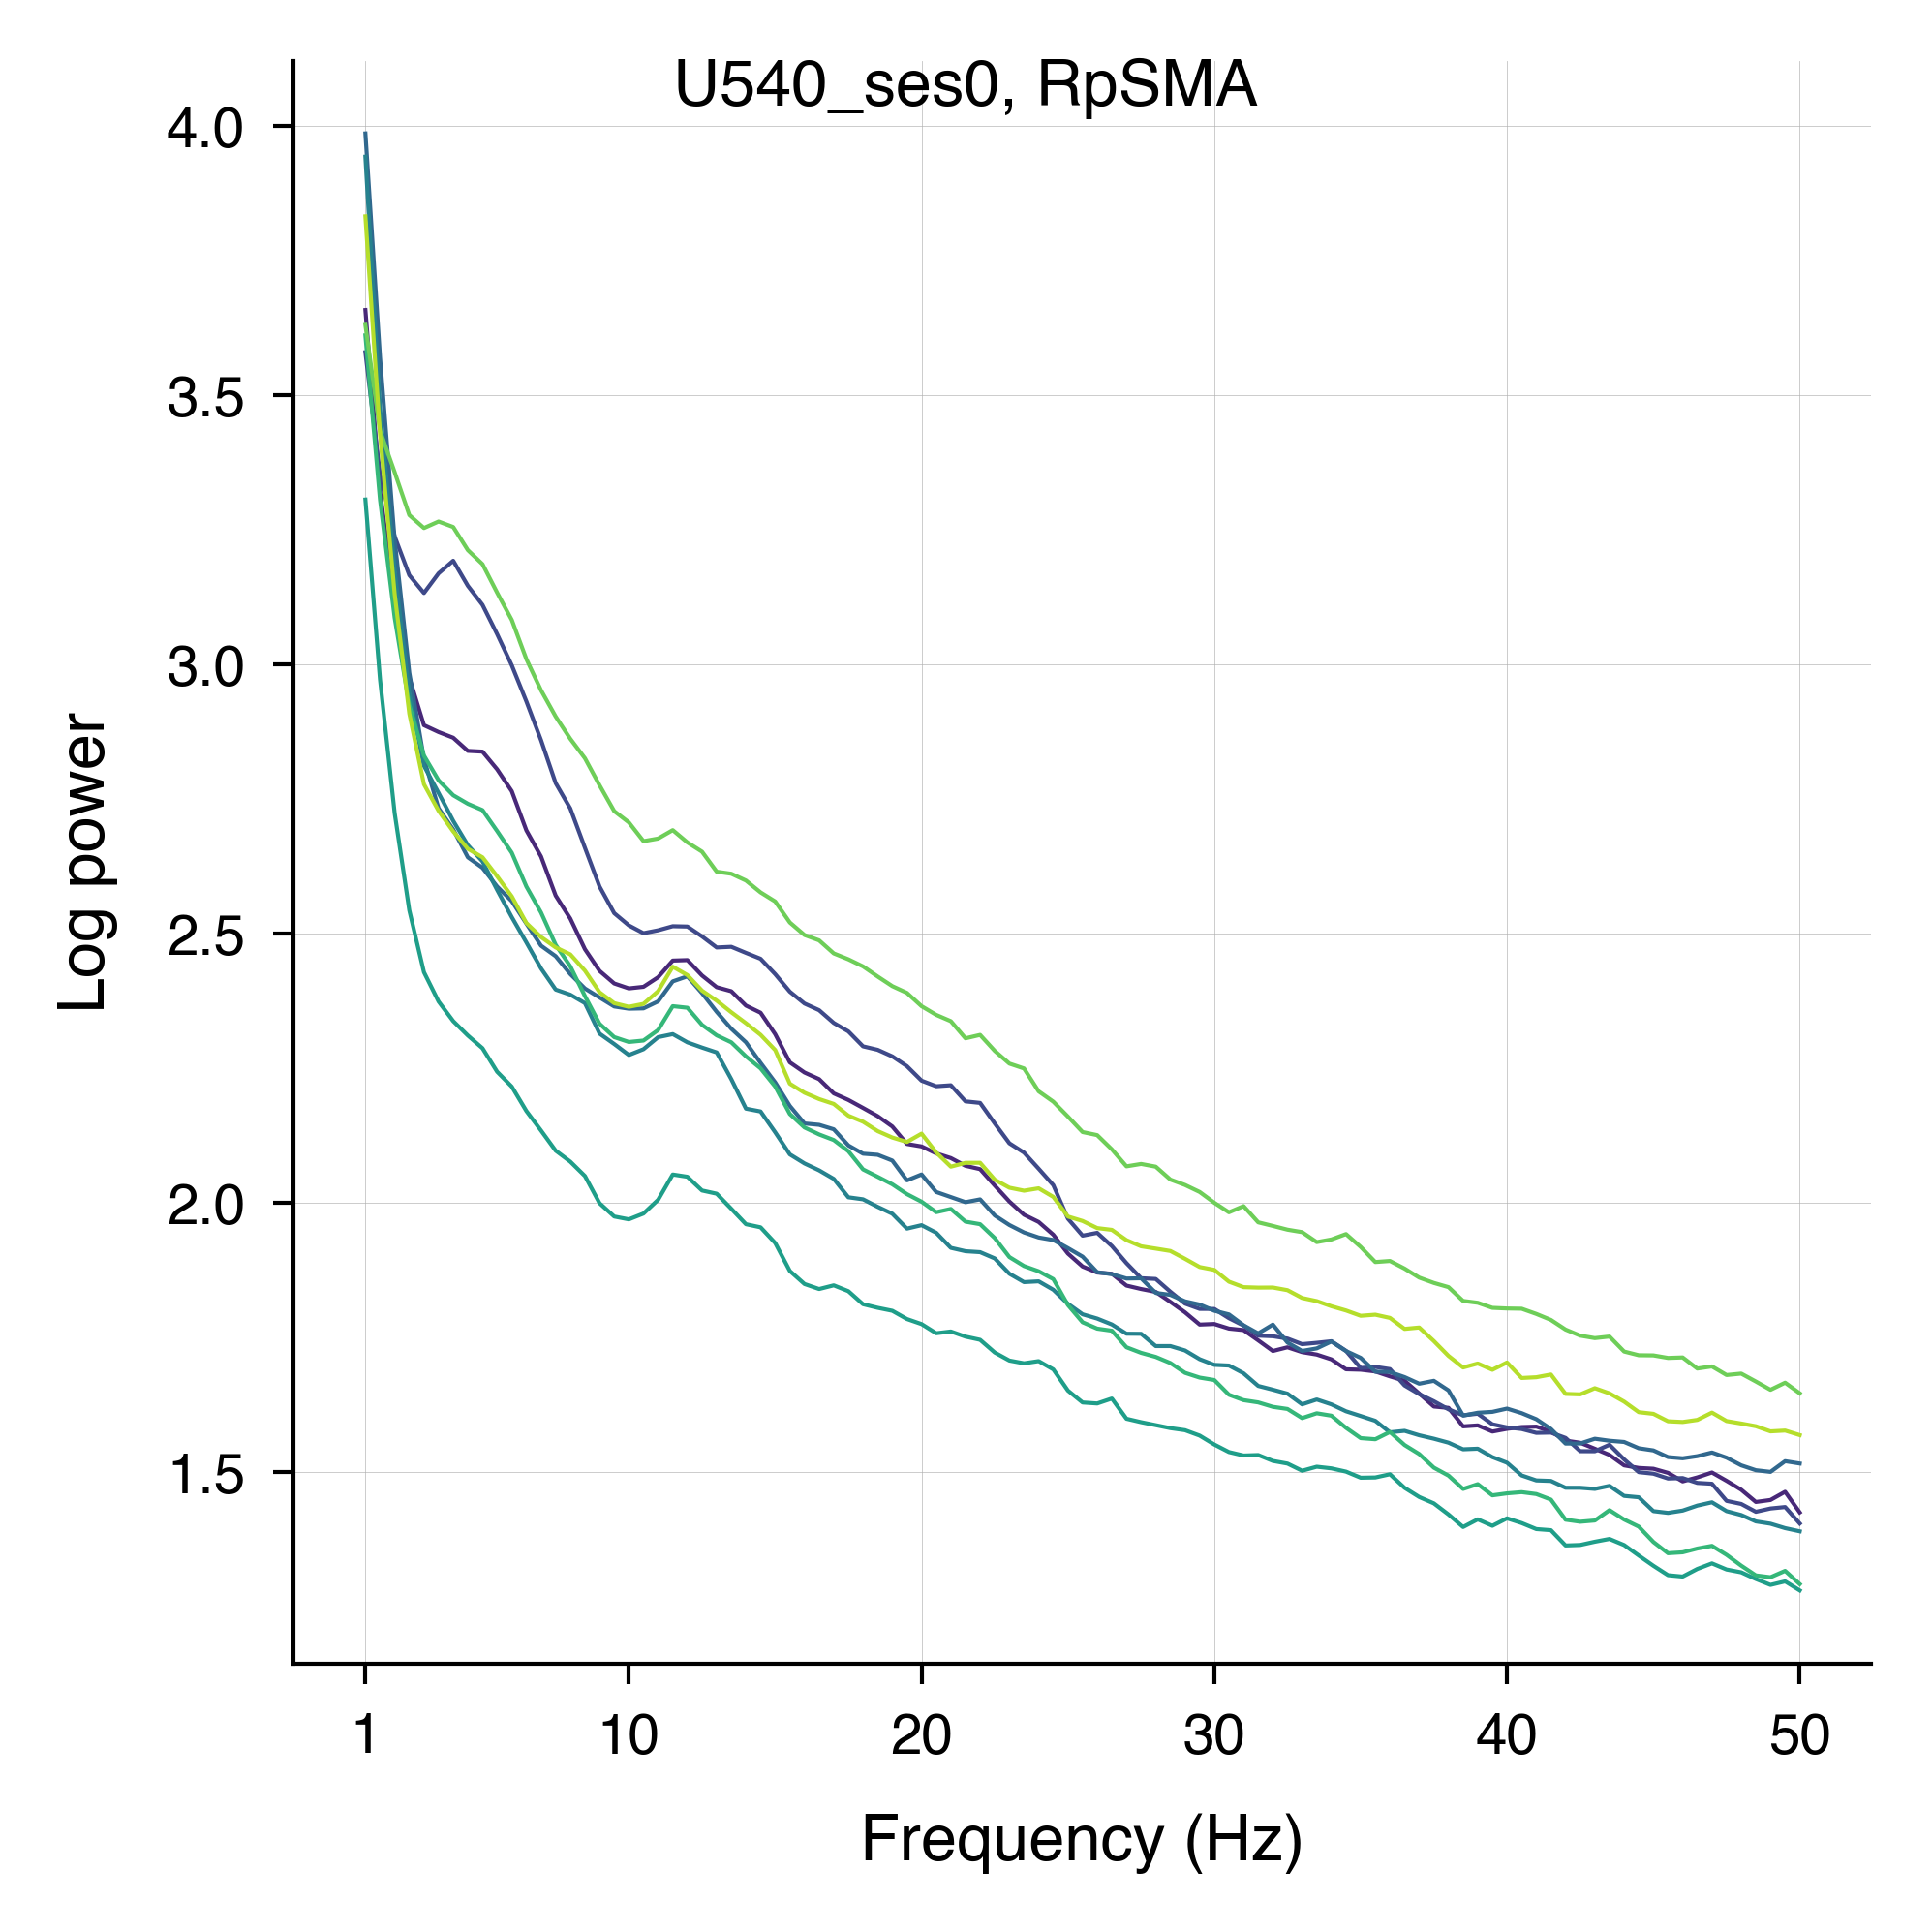

In [1169]:
# Plot the mean power spectrum across navigation intervals
# for all electrodes in each microwire bundle, across sessions.
_sessions = sessions

# EEG proc params.
select_regions = None
game_states = ['Encoding', 'Retrieval']
sr = 1000
buffer = 0
chan_exclusion_thresh = 2
verbose = True

# Power decomp params.
fmin = 1
fmax = 50
n_fft = int(sr * 2)
n_overlap = int(sr)
log_transform = True

# Plot params.
savefig = True
overwrite = True
figsize = (colws[2], colws[2])
dpi = 600
linewidth = 0.5
palette = 'viridis'
font = {'tick': 7, 'label': 8, 'fig': 8, 'annot': 7}
ax_linewidth = 0.5
labelpad = 6
xticklabs = [1, 10, 20, 30, 40, 50]
ticklen = 2.5
tickwidth = 0.5
tickpad = 2.5
show_grid = True

# --------------------------
for subj_sess in _sessions:
    # Load epoched EEG data.
    event_eeg = load_event_eeg(subj_sess,
                               regions=select_regions,
                               game_states=game_states,
                               buffer=buffer,
                               chan_exclusion_thresh=chan_exclusion_thresh,
                               verbose=verbose)
    regions = np.unique([x[0] for x in event_eeg.keys()])
    
    for roi in regions:
        # Get power at each frequency, for every channel x event.
        _eeg = np.concatenate([event_eeg[(roi, game_state)] for game_state in game_states], axis=1)
        _freqs, _powers = timefreq_welch(_eeg,
                                         sr,
                                         fmin=fmin,
                                         fmax=fmax,
                                         n_fft=n_fft,
                                         n_overlap=n_overlap,
                                         log_transform=log_transform)
        mean_powers = np.mean(_powers, axis=1) # channel x frequency
        n_chans, n_freqs = mean_powers.shape
        linecolors = sns.color_palette(palette=palette, n_colors=n_chans)
        xvals = np.arange(n_freqs)
        xticklabs = [freq for freq in xticklabs if (freq in _freqs)]
        xticks = [_freqs.tolist().index(freq) for freq in xticklabs]
        
        # Plot the mean power spectrum for each channel.
        plt.close()
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        ax = np.ravel(ax)

        iax = 0
        _ax = ax[iax]
        for iChan in range(n_chans):
            _ax.plot(xvals, mean_powers[iChan, :], color=linecolors[iChan], lw=linewidth)
        
        # Formatting.
        _ax.grid(show_grid)
        _ax.tick_params(labelsize=font['tick'], axis='both', which='major', length=ticklen, width=tickwidth)
        for spine in ['left', 'bottom']:
            _ax.spines[spine].set_visible(True)
            _ax.spines[spine].set_linewidth(ax_linewidth)
        _ax.set_xticks(xticks)
        _ax.set_xticklabels(xticklabs)
        _ax.set_xlabel('Frequency (Hz)', fontsize=font['label'], labelpad=labelpad)
        _ax.set_ylabel('Log power', fontsize=font['label'], labelpad=labelpad)
        fig.suptitle('{}, {}'.format(subj_sess, roi), fontsize=font['fig'], y=1)
        fig.tight_layout(pad=0)
        
        # Save the plot.
        if savefig:
            filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/elife_revision/goldmine/figs/eeg_spectrums_nav', 
                               '{}_{}.pdf'.format(subj_sess, roi))
            if overwrite or not op.exists(filename):
                fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
                #fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)

fig.show()